In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets
# 모델 요약
from torchvision import models, utils
from torchsummary import summary

In [2]:
# 학습률, batch, epoch
lr = 1e-3
batch_size = 64
num_epoch = 10

# 학습된 network가 저장될 디렉터리
ckpt_dir = 'D:/torchtorch/checkpoint2'
# 텐서보드 파일이 저장될 디렉터리
log_dir = 'D:/torchtorch/log2'
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 네트워크 구축
class Fashion_MNIST_NET(nn.Module) :
    def __init__(self) :
        super(Fashion_MNIST_NET, self).__init__()
        
        # 입력채널 : gray scale이므로 1, 출력 채널(=필터 개수)
        # 10x24x24
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=0, bias=True)
        # 10x12x12
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.relu1 = nn.ReLU()
        
        # 입력채널 : 이전 채널의 출력 개수, 출력 채널(=필터 개수)
        # 20x8x8
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=0, bias=True)
        self.drop2 = nn.Dropout2d(p=0.5)
        # 20x4x4
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.relu2 = nn.ReLU()
        
        # 입력 채널 : 20x4x4(이전 layer flatten), 출력 채널(=Node 개수)
        self.fc1 = nn.Linear(in_features=320, out_features=50, bias=True)
        self.relu1_fc1 = nn.ReLU()
        self.drop1_fc1 = nn.Dropout2d(p=0.5)
        
        # 입력 채널 : 이전 채널의 출력 개수, 마지막층 출력 = 분류하려는 class 개수
        self.fc2 = nn.Linear(in_features=50, out_features=10, bias=True)
     
    # 앞에서 초기화 한 layer들을 연결해준다.
    def forward(self, x) :
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.drop2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        
        # Flatten() -> 입력 채널 맞춰줘야함
        x = x.view(-1, 320)
        
        x = self.fc1(x)
        x = self.relu1_fc1(x)
        x = self.drop1_fc1(x)
        
        x = self.fc2(x)
        
        return x

In [4]:
## 네트워크를 저장하거나 불러오는 함수 작성하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               '%s/model_epoch%d.pth' % (ckpt_dir, epoch))

def load(ckpt_dir, net, optim):
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])

    return net, optim

In [5]:
## MNIST 데이터 불러오기
## 이미지 전처리 과정
# 1. 이미지 텐서 변환 및 정규화 등 수행(.Compose) 
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

# 2. 데이터셋 불러오기
dataset = datasets.FashionMNIST(download=True, root='./.data/', train=True, transform=transform)

# 3. 데이터셋 나누기
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# 4. 1배치에 들어갈 데이터 
# 1epoch = 60000개 = 64batch
# 1batch = 60000/64(batch_size) = 938
num_data = len(loader.dataset)
num_batch = np.ceil(num_data / batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])
torch.Size([64])
tensor([4, 1, 8, 5, 1, 4, 0, 3, 1, 2, 0, 4, 2, 7, 1, 7, 4, 7, 3, 8, 8, 3, 5, 1,
        7, 5, 9, 2, 5, 2, 7, 3, 1, 1, 9, 2, 6, 9, 3, 9, 7, 7, 2, 3, 3, 4, 4, 9,
        1, 6, 1, 8, 0, 8, 9, 0, 8, 5, 5, 5, 6, 4, 3, 9])


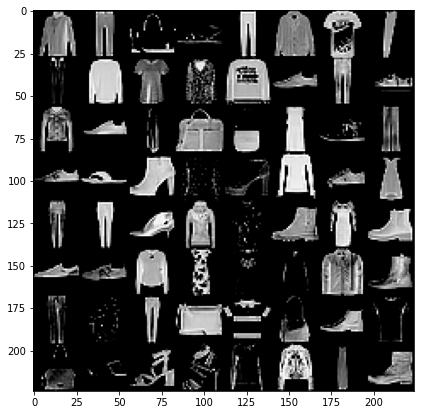

In [6]:
## 데이터셋 시각화하기
# 배치 1개의 image와 label 들을 확인해보기(64개 이미지 존재)
dataiter = iter(loader)
images, labels = next(dataiter)
# 시각화 하기
img = utils.make_grid(images, padding=0)
# 원래 이미지 -> 64개(1epoch, channel, height, width)
print(images.shape)
print(labels.shape)
print(labels)
npimg = img.numpy()
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [7]:
# 클래스 딕셔너리로 만들기
CLASSES = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}
# labels 는 0부터 9까지의 숫자로 이루어져 있다.
# 이를 CLASSES에 있는 index와 일치시킨다.
print(labels)
for label in labels :
    index = label.item()
    print(CLASSES[index])

tensor([4, 1, 8, 5, 1, 4, 0, 3, 1, 2, 0, 4, 2, 7, 1, 7, 4, 7, 3, 8, 8, 3, 5, 1,
        7, 5, 9, 2, 5, 2, 7, 3, 1, 1, 9, 2, 6, 9, 3, 9, 7, 7, 2, 3, 3, 4, 4, 9,
        1, 6, 1, 8, 0, 8, 9, 0, 8, 5, 5, 5, 6, 4, 3, 9])
Coat
Trouser
Bag
Sandal
Trouser
Coat
T-shirt/top
Dress
Trouser
Pullover
T-shirt/top
Coat
Pullover
Sneaker
Trouser
Sneaker
Coat
Sneaker
Dress
Bag
Bag
Dress
Sandal
Trouser
Sneaker
Sandal
Ankle boot
Pullover
Sandal
Pullover
Sneaker
Dress
Trouser
Trouser
Ankle boot
Pullover
Shirt
Ankle boot
Dress
Ankle boot
Sneaker
Sneaker
Pullover
Dress
Dress
Coat
Coat
Ankle boot
Trouser
Shirt
Trouser
Bag
T-shirt/top
Bag
Ankle boot
T-shirt/top
Bag
Sandal
Sandal
Sandal
Shirt
Coat
Dress
Ankle boot


In [8]:
## 네트워크 설정 및 필요한 손실함수 구현하기
net = Fashion_MNIST_NET().to(device)
params = net.parameters()

fn_loss = nn.CrossEntropyLoss().to(device)
fn_pred = lambda output: torch.softmax(output, dim=1)
fn_acc = lambda pred, label: ((pred.max(dim=1)[1] == label).type(torch.float)).mean()

optim = torch.optim.Adam(params, lr=lr)

writer = SummaryWriter(log_dir=log_dir)

In [9]:
## 모델 요약
print(summary(net, (1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         MaxPool2d-2           [-1, 10, 12, 12]               0
              ReLU-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
         Dropout2d-5             [-1, 20, 8, 8]               0
         MaxPool2d-6             [-1, 20, 4, 4]               0
              ReLU-7             [-1, 20, 4, 4]               0
            Linear-8                   [-1, 50]          16,050
              ReLU-9                   [-1, 50]               0
        Dropout2d-10                   [-1, 50]               0
           Linear-11                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [10]:
## 트레이닝 시작하기
st_epoch = 0
for epoch in range(st_epoch + 1, num_epoch + 1):
    net.train()

    loss_arr = []
    acc_arr = []

    for  batch, (input, label) in enumerate(loader, 1):
        
        input = input.to(device)
        # input shape = (batch, channel, height, width)
#         print(input.shape)
        
        label = label.to(device)
        # label shape = (batch)
#         print(label.shape)
        
        output = net(input)
        # output shape = (batch, 10)
#         print(output.shape)
        
        # pred shape = (batch, 10)
        pred = fn_pred(output)
#         print(pred.shape)
        
        # 모든 model parameter의 gradient를 0으로 설정한다.(epoch마다 새롭게, loss 증가 방지)
        optim.zero_grad()

        # loss와 acc를 계산
        loss = fn_loss(output, label)
        acc = fn_acc(pred, label)
    
        # loss와 chain rule를 통해 각 layer의 gradient를 계산한다.
        loss.backward()
        
        # parameter를 update한다.
        optim.step()

        loss_arr += [loss.item()]
        acc_arr += [acc.item()]

        print('TRAIN: EPOCH %04d/%04d | BATCH %04d/%04d | LOSS: %.4f | ACC %.4f' %
              (epoch, num_epoch, batch, num_batch, np.mean(loss_arr), np.mean(acc_arr)))
    
    writer.add_scalar('loss', np.mean(loss_arr), epoch)
    writer.add_scalar('acc', np.mean(acc_arr), epoch)

    save(ckpt_dir = ckpt_dir, net=net, optim=optim, epoch=epoch)

writer.close()

TRAIN: EPOCH 0001/0010 | BATCH 0001/0938 | LOSS: 2.3183 | ACC 0.0781
TRAIN: EPOCH 0001/0010 | BATCH 0002/0938 | LOSS: 2.3123 | ACC 0.1094
TRAIN: EPOCH 0001/0010 | BATCH 0003/0938 | LOSS: 2.2996 | ACC 0.1146
TRAIN: EPOCH 0001/0010 | BATCH 0004/0938 | LOSS: 2.2987 | ACC 0.1367
TRAIN: EPOCH 0001/0010 | BATCH 0005/0938 | LOSS: 2.2985 | ACC 0.1313
TRAIN: EPOCH 0001/0010 | BATCH 0006/0938 | LOSS: 2.2977 | ACC 0.1432
TRAIN: EPOCH 0001/0010 | BATCH 0007/0938 | LOSS: 2.2945 | ACC 0.1473
TRAIN: EPOCH 0001/0010 | BATCH 0008/0938 | LOSS: 2.2969 | ACC 0.1426
TRAIN: EPOCH 0001/0010 | BATCH 0009/0938 | LOSS: 2.2962 | ACC 0.1441
TRAIN: EPOCH 0001/0010 | BATCH 0010/0938 | LOSS: 2.2942 | ACC 0.1437
TRAIN: EPOCH 0001/0010 | BATCH 0011/0938 | LOSS: 2.2920 | ACC 0.1406
TRAIN: EPOCH 0001/0010 | BATCH 0012/0938 | LOSS: 2.2858 | ACC 0.1576
TRAIN: EPOCH 0001/0010 | BATCH 0013/0938 | LOSS: 2.2802 | ACC 0.1599
TRAIN: EPOCH 0001/0010 | BATCH 0014/0938 | LOSS: 2.2755 | ACC 0.1685
TRAIN: EPOCH 0001/0010 | BATCH 001

TRAIN: EPOCH 0001/0010 | BATCH 0127/0938 | LOSS: 1.5819 | ACC 0.4320
TRAIN: EPOCH 0001/0010 | BATCH 0128/0938 | LOSS: 1.5783 | ACC 0.4329
TRAIN: EPOCH 0001/0010 | BATCH 0129/0938 | LOSS: 1.5751 | ACC 0.4340
TRAIN: EPOCH 0001/0010 | BATCH 0130/0938 | LOSS: 1.5707 | ACC 0.4357
TRAIN: EPOCH 0001/0010 | BATCH 0131/0938 | LOSS: 1.5680 | ACC 0.4364
TRAIN: EPOCH 0001/0010 | BATCH 0132/0938 | LOSS: 1.5638 | ACC 0.4379
TRAIN: EPOCH 0001/0010 | BATCH 0133/0938 | LOSS: 1.5606 | ACC 0.4391
TRAIN: EPOCH 0001/0010 | BATCH 0134/0938 | LOSS: 1.5584 | ACC 0.4396
TRAIN: EPOCH 0001/0010 | BATCH 0135/0938 | LOSS: 1.5544 | ACC 0.4405
TRAIN: EPOCH 0001/0010 | BATCH 0136/0938 | LOSS: 1.5500 | ACC 0.4422
TRAIN: EPOCH 0001/0010 | BATCH 0137/0938 | LOSS: 1.5471 | ACC 0.4435
TRAIN: EPOCH 0001/0010 | BATCH 0138/0938 | LOSS: 1.5427 | ACC 0.4446
TRAIN: EPOCH 0001/0010 | BATCH 0139/0938 | LOSS: 1.5399 | ACC 0.4458
TRAIN: EPOCH 0001/0010 | BATCH 0140/0938 | LOSS: 1.5352 | ACC 0.4479
TRAIN: EPOCH 0001/0010 | BATCH 014

TRAIN: EPOCH 0001/0010 | BATCH 0247/0938 | LOSS: 1.2896 | ACC 0.5338
TRAIN: EPOCH 0001/0010 | BATCH 0248/0938 | LOSS: 1.2879 | ACC 0.5347
TRAIN: EPOCH 0001/0010 | BATCH 0249/0938 | LOSS: 1.2868 | ACC 0.5350
TRAIN: EPOCH 0001/0010 | BATCH 0250/0938 | LOSS: 1.2848 | ACC 0.5357
TRAIN: EPOCH 0001/0010 | BATCH 0251/0938 | LOSS: 1.2833 | ACC 0.5364
TRAIN: EPOCH 0001/0010 | BATCH 0252/0938 | LOSS: 1.2814 | ACC 0.5368
TRAIN: EPOCH 0001/0010 | BATCH 0253/0938 | LOSS: 1.2801 | ACC 0.5376
TRAIN: EPOCH 0001/0010 | BATCH 0254/0938 | LOSS: 1.2785 | ACC 0.5382
TRAIN: EPOCH 0001/0010 | BATCH 0255/0938 | LOSS: 1.2764 | ACC 0.5391
TRAIN: EPOCH 0001/0010 | BATCH 0256/0938 | LOSS: 1.2749 | ACC 0.5396
TRAIN: EPOCH 0001/0010 | BATCH 0257/0938 | LOSS: 1.2730 | ACC 0.5402
TRAIN: EPOCH 0001/0010 | BATCH 0258/0938 | LOSS: 1.2716 | ACC 0.5405
TRAIN: EPOCH 0001/0010 | BATCH 0259/0938 | LOSS: 1.2696 | ACC 0.5411
TRAIN: EPOCH 0001/0010 | BATCH 0260/0938 | LOSS: 1.2682 | ACC 0.5416
TRAIN: EPOCH 0001/0010 | BATCH 026

TRAIN: EPOCH 0001/0010 | BATCH 0376/0938 | LOSS: 1.1417 | ACC 0.5849
TRAIN: EPOCH 0001/0010 | BATCH 0377/0938 | LOSS: 1.1402 | ACC 0.5855
TRAIN: EPOCH 0001/0010 | BATCH 0378/0938 | LOSS: 1.1396 | ACC 0.5855
TRAIN: EPOCH 0001/0010 | BATCH 0379/0938 | LOSS: 1.1389 | ACC 0.5858
TRAIN: EPOCH 0001/0010 | BATCH 0380/0938 | LOSS: 1.1381 | ACC 0.5861
TRAIN: EPOCH 0001/0010 | BATCH 0381/0938 | LOSS: 1.1373 | ACC 0.5864
TRAIN: EPOCH 0001/0010 | BATCH 0382/0938 | LOSS: 1.1363 | ACC 0.5866
TRAIN: EPOCH 0001/0010 | BATCH 0383/0938 | LOSS: 1.1358 | ACC 0.5870
TRAIN: EPOCH 0001/0010 | BATCH 0384/0938 | LOSS: 1.1354 | ACC 0.5872
TRAIN: EPOCH 0001/0010 | BATCH 0385/0938 | LOSS: 1.1346 | ACC 0.5875
TRAIN: EPOCH 0001/0010 | BATCH 0386/0938 | LOSS: 1.1339 | ACC 0.5876
TRAIN: EPOCH 0001/0010 | BATCH 0387/0938 | LOSS: 1.1333 | ACC 0.5877
TRAIN: EPOCH 0001/0010 | BATCH 0388/0938 | LOSS: 1.1324 | ACC 0.5880
TRAIN: EPOCH 0001/0010 | BATCH 0389/0938 | LOSS: 1.1317 | ACC 0.5884
TRAIN: EPOCH 0001/0010 | BATCH 039

TRAIN: EPOCH 0001/0010 | BATCH 0494/0938 | LOSS: 1.0611 | ACC 0.6131
TRAIN: EPOCH 0001/0010 | BATCH 0495/0938 | LOSS: 1.0599 | ACC 0.6135
TRAIN: EPOCH 0001/0010 | BATCH 0496/0938 | LOSS: 1.0595 | ACC 0.6136
TRAIN: EPOCH 0001/0010 | BATCH 0497/0938 | LOSS: 1.0594 | ACC 0.6136
TRAIN: EPOCH 0001/0010 | BATCH 0498/0938 | LOSS: 1.0585 | ACC 0.6138
TRAIN: EPOCH 0001/0010 | BATCH 0499/0938 | LOSS: 1.0579 | ACC 0.6140
TRAIN: EPOCH 0001/0010 | BATCH 0500/0938 | LOSS: 1.0569 | ACC 0.6143
TRAIN: EPOCH 0001/0010 | BATCH 0501/0938 | LOSS: 1.0563 | ACC 0.6145
TRAIN: EPOCH 0001/0010 | BATCH 0502/0938 | LOSS: 1.0559 | ACC 0.6147
TRAIN: EPOCH 0001/0010 | BATCH 0503/0938 | LOSS: 1.0552 | ACC 0.6148
TRAIN: EPOCH 0001/0010 | BATCH 0504/0938 | LOSS: 1.0550 | ACC 0.6148
TRAIN: EPOCH 0001/0010 | BATCH 0505/0938 | LOSS: 1.0544 | ACC 0.6150
TRAIN: EPOCH 0001/0010 | BATCH 0506/0938 | LOSS: 1.0536 | ACC 0.6153
TRAIN: EPOCH 0001/0010 | BATCH 0507/0938 | LOSS: 1.0530 | ACC 0.6154
TRAIN: EPOCH 0001/0010 | BATCH 050

TRAIN: EPOCH 0001/0010 | BATCH 0614/0938 | LOSS: 0.9952 | ACC 0.6356
TRAIN: EPOCH 0001/0010 | BATCH 0615/0938 | LOSS: 0.9945 | ACC 0.6358
TRAIN: EPOCH 0001/0010 | BATCH 0616/0938 | LOSS: 0.9938 | ACC 0.6360
TRAIN: EPOCH 0001/0010 | BATCH 0617/0938 | LOSS: 0.9934 | ACC 0.6362
TRAIN: EPOCH 0001/0010 | BATCH 0618/0938 | LOSS: 0.9931 | ACC 0.6364
TRAIN: EPOCH 0001/0010 | BATCH 0619/0938 | LOSS: 0.9925 | ACC 0.6365
TRAIN: EPOCH 0001/0010 | BATCH 0620/0938 | LOSS: 0.9920 | ACC 0.6367
TRAIN: EPOCH 0001/0010 | BATCH 0621/0938 | LOSS: 0.9917 | ACC 0.6368
TRAIN: EPOCH 0001/0010 | BATCH 0622/0938 | LOSS: 0.9912 | ACC 0.6371
TRAIN: EPOCH 0001/0010 | BATCH 0623/0938 | LOSS: 0.9909 | ACC 0.6372
TRAIN: EPOCH 0001/0010 | BATCH 0624/0938 | LOSS: 0.9905 | ACC 0.6374
TRAIN: EPOCH 0001/0010 | BATCH 0625/0938 | LOSS: 0.9900 | ACC 0.6374
TRAIN: EPOCH 0001/0010 | BATCH 0626/0938 | LOSS: 0.9895 | ACC 0.6377
TRAIN: EPOCH 0001/0010 | BATCH 0627/0938 | LOSS: 0.9889 | ACC 0.6379
TRAIN: EPOCH 0001/0010 | BATCH 062

TRAIN: EPOCH 0001/0010 | BATCH 0732/0938 | LOSS: 0.9502 | ACC 0.6512
TRAIN: EPOCH 0001/0010 | BATCH 0733/0938 | LOSS: 0.9501 | ACC 0.6513
TRAIN: EPOCH 0001/0010 | BATCH 0734/0938 | LOSS: 0.9495 | ACC 0.6516
TRAIN: EPOCH 0001/0010 | BATCH 0735/0938 | LOSS: 0.9491 | ACC 0.6517
TRAIN: EPOCH 0001/0010 | BATCH 0736/0938 | LOSS: 0.9490 | ACC 0.6517
TRAIN: EPOCH 0001/0010 | BATCH 0737/0938 | LOSS: 0.9486 | ACC 0.6519
TRAIN: EPOCH 0001/0010 | BATCH 0738/0938 | LOSS: 0.9487 | ACC 0.6519
TRAIN: EPOCH 0001/0010 | BATCH 0739/0938 | LOSS: 0.9484 | ACC 0.6520
TRAIN: EPOCH 0001/0010 | BATCH 0740/0938 | LOSS: 0.9480 | ACC 0.6521
TRAIN: EPOCH 0001/0010 | BATCH 0741/0938 | LOSS: 0.9479 | ACC 0.6523
TRAIN: EPOCH 0001/0010 | BATCH 0742/0938 | LOSS: 0.9474 | ACC 0.6526
TRAIN: EPOCH 0001/0010 | BATCH 0743/0938 | LOSS: 0.9470 | ACC 0.6527
TRAIN: EPOCH 0001/0010 | BATCH 0744/0938 | LOSS: 0.9469 | ACC 0.6526
TRAIN: EPOCH 0001/0010 | BATCH 0745/0938 | LOSS: 0.9465 | ACC 0.6528
TRAIN: EPOCH 0001/0010 | BATCH 074

TRAIN: EPOCH 0001/0010 | BATCH 0855/0938 | LOSS: 0.9142 | ACC 0.6647
TRAIN: EPOCH 0001/0010 | BATCH 0856/0938 | LOSS: 0.9143 | ACC 0.6646
TRAIN: EPOCH 0001/0010 | BATCH 0857/0938 | LOSS: 0.9140 | ACC 0.6647
TRAIN: EPOCH 0001/0010 | BATCH 0858/0938 | LOSS: 0.9138 | ACC 0.6648
TRAIN: EPOCH 0001/0010 | BATCH 0859/0938 | LOSS: 0.9135 | ACC 0.6649
TRAIN: EPOCH 0001/0010 | BATCH 0860/0938 | LOSS: 0.9135 | ACC 0.6650
TRAIN: EPOCH 0001/0010 | BATCH 0861/0938 | LOSS: 0.9134 | ACC 0.6650
TRAIN: EPOCH 0001/0010 | BATCH 0862/0938 | LOSS: 0.9131 | ACC 0.6651
TRAIN: EPOCH 0001/0010 | BATCH 0863/0938 | LOSS: 0.9129 | ACC 0.6652
TRAIN: EPOCH 0001/0010 | BATCH 0864/0938 | LOSS: 0.9127 | ACC 0.6652
TRAIN: EPOCH 0001/0010 | BATCH 0865/0938 | LOSS: 0.9124 | ACC 0.6652
TRAIN: EPOCH 0001/0010 | BATCH 0866/0938 | LOSS: 0.9124 | ACC 0.6652
TRAIN: EPOCH 0001/0010 | BATCH 0867/0938 | LOSS: 0.9121 | ACC 0.6653
TRAIN: EPOCH 0001/0010 | BATCH 0868/0938 | LOSS: 0.9119 | ACC 0.6654
TRAIN: EPOCH 0001/0010 | BATCH 086

TRAIN: EPOCH 0002/0010 | BATCH 0040/0938 | LOSS: 0.6543 | ACC 0.7594
TRAIN: EPOCH 0002/0010 | BATCH 0041/0938 | LOSS: 0.6487 | ACC 0.7611
TRAIN: EPOCH 0002/0010 | BATCH 0042/0938 | LOSS: 0.6494 | ACC 0.7619
TRAIN: EPOCH 0002/0010 | BATCH 0043/0938 | LOSS: 0.6488 | ACC 0.7620
TRAIN: EPOCH 0002/0010 | BATCH 0044/0938 | LOSS: 0.6506 | ACC 0.7610
TRAIN: EPOCH 0002/0010 | BATCH 0045/0938 | LOSS: 0.6503 | ACC 0.7608
TRAIN: EPOCH 0002/0010 | BATCH 0046/0938 | LOSS: 0.6494 | ACC 0.7605
TRAIN: EPOCH 0002/0010 | BATCH 0047/0938 | LOSS: 0.6489 | ACC 0.7596
TRAIN: EPOCH 0002/0010 | BATCH 0048/0938 | LOSS: 0.6530 | ACC 0.7604
TRAIN: EPOCH 0002/0010 | BATCH 0049/0938 | LOSS: 0.6517 | ACC 0.7618
TRAIN: EPOCH 0002/0010 | BATCH 0050/0938 | LOSS: 0.6492 | ACC 0.7622
TRAIN: EPOCH 0002/0010 | BATCH 0051/0938 | LOSS: 0.6487 | ACC 0.7619
TRAIN: EPOCH 0002/0010 | BATCH 0052/0938 | LOSS: 0.6490 | ACC 0.7608
TRAIN: EPOCH 0002/0010 | BATCH 0053/0938 | LOSS: 0.6505 | ACC 0.7609
TRAIN: EPOCH 0002/0010 | BATCH 005

TRAIN: EPOCH 0002/0010 | BATCH 0161/0938 | LOSS: 0.6520 | ACC 0.7623
TRAIN: EPOCH 0002/0010 | BATCH 0162/0938 | LOSS: 0.6512 | ACC 0.7626
TRAIN: EPOCH 0002/0010 | BATCH 0163/0938 | LOSS: 0.6517 | ACC 0.7623
TRAIN: EPOCH 0002/0010 | BATCH 0164/0938 | LOSS: 0.6509 | ACC 0.7626
TRAIN: EPOCH 0002/0010 | BATCH 0165/0938 | LOSS: 0.6504 | ACC 0.7629
TRAIN: EPOCH 0002/0010 | BATCH 0166/0938 | LOSS: 0.6507 | ACC 0.7624
TRAIN: EPOCH 0002/0010 | BATCH 0167/0938 | LOSS: 0.6509 | ACC 0.7625
TRAIN: EPOCH 0002/0010 | BATCH 0168/0938 | LOSS: 0.6522 | ACC 0.7619
TRAIN: EPOCH 0002/0010 | BATCH 0169/0938 | LOSS: 0.6526 | ACC 0.7619
TRAIN: EPOCH 0002/0010 | BATCH 0170/0938 | LOSS: 0.6520 | ACC 0.7617
TRAIN: EPOCH 0002/0010 | BATCH 0171/0938 | LOSS: 0.6530 | ACC 0.7615
TRAIN: EPOCH 0002/0010 | BATCH 0172/0938 | LOSS: 0.6534 | ACC 0.7613
TRAIN: EPOCH 0002/0010 | BATCH 0173/0938 | LOSS: 0.6530 | ACC 0.7613
TRAIN: EPOCH 0002/0010 | BATCH 0174/0938 | LOSS: 0.6520 | ACC 0.7619
TRAIN: EPOCH 0002/0010 | BATCH 017

TRAIN: EPOCH 0002/0010 | BATCH 0280/0938 | LOSS: 0.6578 | ACC 0.7612
TRAIN: EPOCH 0002/0010 | BATCH 0281/0938 | LOSS: 0.6573 | ACC 0.7613
TRAIN: EPOCH 0002/0010 | BATCH 0282/0938 | LOSS: 0.6582 | ACC 0.7612
TRAIN: EPOCH 0002/0010 | BATCH 0283/0938 | LOSS: 0.6579 | ACC 0.7614
TRAIN: EPOCH 0002/0010 | BATCH 0284/0938 | LOSS: 0.6577 | ACC 0.7616
TRAIN: EPOCH 0002/0010 | BATCH 0285/0938 | LOSS: 0.6572 | ACC 0.7618
TRAIN: EPOCH 0002/0010 | BATCH 0286/0938 | LOSS: 0.6568 | ACC 0.7620
TRAIN: EPOCH 0002/0010 | BATCH 0287/0938 | LOSS: 0.6576 | ACC 0.7617
TRAIN: EPOCH 0002/0010 | BATCH 0288/0938 | LOSS: 0.6573 | ACC 0.7616
TRAIN: EPOCH 0002/0010 | BATCH 0289/0938 | LOSS: 0.6578 | ACC 0.7614
TRAIN: EPOCH 0002/0010 | BATCH 0290/0938 | LOSS: 0.6576 | ACC 0.7615
TRAIN: EPOCH 0002/0010 | BATCH 0291/0938 | LOSS: 0.6579 | ACC 0.7615
TRAIN: EPOCH 0002/0010 | BATCH 0292/0938 | LOSS: 0.6576 | ACC 0.7617
TRAIN: EPOCH 0002/0010 | BATCH 0293/0938 | LOSS: 0.6574 | ACC 0.7618
TRAIN: EPOCH 0002/0010 | BATCH 029

TRAIN: EPOCH 0002/0010 | BATCH 0403/0938 | LOSS: 0.6502 | ACC 0.7650
TRAIN: EPOCH 0002/0010 | BATCH 0404/0938 | LOSS: 0.6499 | ACC 0.7652
TRAIN: EPOCH 0002/0010 | BATCH 0405/0938 | LOSS: 0.6495 | ACC 0.7654
TRAIN: EPOCH 0002/0010 | BATCH 0406/0938 | LOSS: 0.6498 | ACC 0.7655
TRAIN: EPOCH 0002/0010 | BATCH 0407/0938 | LOSS: 0.6501 | ACC 0.7652
TRAIN: EPOCH 0002/0010 | BATCH 0408/0938 | LOSS: 0.6501 | ACC 0.7652
TRAIN: EPOCH 0002/0010 | BATCH 0409/0938 | LOSS: 0.6504 | ACC 0.7650
TRAIN: EPOCH 0002/0010 | BATCH 0410/0938 | LOSS: 0.6501 | ACC 0.7651
TRAIN: EPOCH 0002/0010 | BATCH 0411/0938 | LOSS: 0.6498 | ACC 0.7652
TRAIN: EPOCH 0002/0010 | BATCH 0412/0938 | LOSS: 0.6497 | ACC 0.7652
TRAIN: EPOCH 0002/0010 | BATCH 0413/0938 | LOSS: 0.6498 | ACC 0.7652
TRAIN: EPOCH 0002/0010 | BATCH 0414/0938 | LOSS: 0.6500 | ACC 0.7650
TRAIN: EPOCH 0002/0010 | BATCH 0415/0938 | LOSS: 0.6498 | ACC 0.7649
TRAIN: EPOCH 0002/0010 | BATCH 0416/0938 | LOSS: 0.6499 | ACC 0.7648
TRAIN: EPOCH 0002/0010 | BATCH 041

TRAIN: EPOCH 0002/0010 | BATCH 0525/0938 | LOSS: 0.6446 | ACC 0.7660
TRAIN: EPOCH 0002/0010 | BATCH 0526/0938 | LOSS: 0.6444 | ACC 0.7660
TRAIN: EPOCH 0002/0010 | BATCH 0527/0938 | LOSS: 0.6445 | ACC 0.7658
TRAIN: EPOCH 0002/0010 | BATCH 0528/0938 | LOSS: 0.6443 | ACC 0.7659
TRAIN: EPOCH 0002/0010 | BATCH 0529/0938 | LOSS: 0.6444 | ACC 0.7659
TRAIN: EPOCH 0002/0010 | BATCH 0530/0938 | LOSS: 0.6445 | ACC 0.7657
TRAIN: EPOCH 0002/0010 | BATCH 0531/0938 | LOSS: 0.6445 | ACC 0.7657
TRAIN: EPOCH 0002/0010 | BATCH 0532/0938 | LOSS: 0.6442 | ACC 0.7659
TRAIN: EPOCH 0002/0010 | BATCH 0533/0938 | LOSS: 0.6439 | ACC 0.7660
TRAIN: EPOCH 0002/0010 | BATCH 0534/0938 | LOSS: 0.6437 | ACC 0.7661
TRAIN: EPOCH 0002/0010 | BATCH 0535/0938 | LOSS: 0.6437 | ACC 0.7662
TRAIN: EPOCH 0002/0010 | BATCH 0536/0938 | LOSS: 0.6436 | ACC 0.7662
TRAIN: EPOCH 0002/0010 | BATCH 0537/0938 | LOSS: 0.6434 | ACC 0.7661
TRAIN: EPOCH 0002/0010 | BATCH 0538/0938 | LOSS: 0.6435 | ACC 0.7661
TRAIN: EPOCH 0002/0010 | BATCH 053

TRAIN: EPOCH 0002/0010 | BATCH 0646/0938 | LOSS: 0.6366 | ACC 0.7684
TRAIN: EPOCH 0002/0010 | BATCH 0647/0938 | LOSS: 0.6362 | ACC 0.7685
TRAIN: EPOCH 0002/0010 | BATCH 0648/0938 | LOSS: 0.6362 | ACC 0.7685
TRAIN: EPOCH 0002/0010 | BATCH 0649/0938 | LOSS: 0.6366 | ACC 0.7685
TRAIN: EPOCH 0002/0010 | BATCH 0650/0938 | LOSS: 0.6366 | ACC 0.7684
TRAIN: EPOCH 0002/0010 | BATCH 0651/0938 | LOSS: 0.6364 | ACC 0.7684
TRAIN: EPOCH 0002/0010 | BATCH 0652/0938 | LOSS: 0.6362 | ACC 0.7685
TRAIN: EPOCH 0002/0010 | BATCH 0653/0938 | LOSS: 0.6360 | ACC 0.7686
TRAIN: EPOCH 0002/0010 | BATCH 0654/0938 | LOSS: 0.6358 | ACC 0.7686
TRAIN: EPOCH 0002/0010 | BATCH 0655/0938 | LOSS: 0.6359 | ACC 0.7685
TRAIN: EPOCH 0002/0010 | BATCH 0656/0938 | LOSS: 0.6361 | ACC 0.7685
TRAIN: EPOCH 0002/0010 | BATCH 0657/0938 | LOSS: 0.6362 | ACC 0.7685
TRAIN: EPOCH 0002/0010 | BATCH 0658/0938 | LOSS: 0.6365 | ACC 0.7684
TRAIN: EPOCH 0002/0010 | BATCH 0659/0938 | LOSS: 0.6366 | ACC 0.7683
TRAIN: EPOCH 0002/0010 | BATCH 066

TRAIN: EPOCH 0002/0010 | BATCH 0765/0938 | LOSS: 0.6318 | ACC 0.7701
TRAIN: EPOCH 0002/0010 | BATCH 0766/0938 | LOSS: 0.6317 | ACC 0.7701
TRAIN: EPOCH 0002/0010 | BATCH 0767/0938 | LOSS: 0.6316 | ACC 0.7702
TRAIN: EPOCH 0002/0010 | BATCH 0768/0938 | LOSS: 0.6319 | ACC 0.7702
TRAIN: EPOCH 0002/0010 | BATCH 0769/0938 | LOSS: 0.6318 | ACC 0.7702
TRAIN: EPOCH 0002/0010 | BATCH 0770/0938 | LOSS: 0.6317 | ACC 0.7702
TRAIN: EPOCH 0002/0010 | BATCH 0771/0938 | LOSS: 0.6319 | ACC 0.7701
TRAIN: EPOCH 0002/0010 | BATCH 0772/0938 | LOSS: 0.6321 | ACC 0.7700
TRAIN: EPOCH 0002/0010 | BATCH 0773/0938 | LOSS: 0.6321 | ACC 0.7701
TRAIN: EPOCH 0002/0010 | BATCH 0774/0938 | LOSS: 0.6319 | ACC 0.7701
TRAIN: EPOCH 0002/0010 | BATCH 0775/0938 | LOSS: 0.6317 | ACC 0.7702
TRAIN: EPOCH 0002/0010 | BATCH 0776/0938 | LOSS: 0.6314 | ACC 0.7704
TRAIN: EPOCH 0002/0010 | BATCH 0777/0938 | LOSS: 0.6314 | ACC 0.7703
TRAIN: EPOCH 0002/0010 | BATCH 0778/0938 | LOSS: 0.6311 | ACC 0.7705
TRAIN: EPOCH 0002/0010 | BATCH 077

TRAIN: EPOCH 0002/0010 | BATCH 0887/0938 | LOSS: 0.6294 | ACC 0.7710
TRAIN: EPOCH 0002/0010 | BATCH 0888/0938 | LOSS: 0.6292 | ACC 0.7710
TRAIN: EPOCH 0002/0010 | BATCH 0889/0938 | LOSS: 0.6290 | ACC 0.7711
TRAIN: EPOCH 0002/0010 | BATCH 0890/0938 | LOSS: 0.6289 | ACC 0.7712
TRAIN: EPOCH 0002/0010 | BATCH 0891/0938 | LOSS: 0.6289 | ACC 0.7712
TRAIN: EPOCH 0002/0010 | BATCH 0892/0938 | LOSS: 0.6289 | ACC 0.7711
TRAIN: EPOCH 0002/0010 | BATCH 0893/0938 | LOSS: 0.6287 | ACC 0.7712
TRAIN: EPOCH 0002/0010 | BATCH 0894/0938 | LOSS: 0.6286 | ACC 0.7712
TRAIN: EPOCH 0002/0010 | BATCH 0895/0938 | LOSS: 0.6284 | ACC 0.7712
TRAIN: EPOCH 0002/0010 | BATCH 0896/0938 | LOSS: 0.6284 | ACC 0.7713
TRAIN: EPOCH 0002/0010 | BATCH 0897/0938 | LOSS: 0.6282 | ACC 0.7713
TRAIN: EPOCH 0002/0010 | BATCH 0898/0938 | LOSS: 0.6280 | ACC 0.7715
TRAIN: EPOCH 0002/0010 | BATCH 0899/0938 | LOSS: 0.6280 | ACC 0.7715
TRAIN: EPOCH 0002/0010 | BATCH 0900/0938 | LOSS: 0.6280 | ACC 0.7715
TRAIN: EPOCH 0002/0010 | BATCH 090

TRAIN: EPOCH 0003/0010 | BATCH 0071/0938 | LOSS: 0.6052 | ACC 0.7870
TRAIN: EPOCH 0003/0010 | BATCH 0072/0938 | LOSS: 0.6048 | ACC 0.7873
TRAIN: EPOCH 0003/0010 | BATCH 0073/0938 | LOSS: 0.6029 | ACC 0.7875
TRAIN: EPOCH 0003/0010 | BATCH 0074/0938 | LOSS: 0.6006 | ACC 0.7880
TRAIN: EPOCH 0003/0010 | BATCH 0075/0938 | LOSS: 0.6011 | ACC 0.7875
TRAIN: EPOCH 0003/0010 | BATCH 0076/0938 | LOSS: 0.5998 | ACC 0.7882
TRAIN: EPOCH 0003/0010 | BATCH 0077/0938 | LOSS: 0.5970 | ACC 0.7888
TRAIN: EPOCH 0003/0010 | BATCH 0078/0938 | LOSS: 0.5965 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 0079/0938 | LOSS: 0.5941 | ACC 0.7898
TRAIN: EPOCH 0003/0010 | BATCH 0080/0938 | LOSS: 0.5927 | ACC 0.7902
TRAIN: EPOCH 0003/0010 | BATCH 0081/0938 | LOSS: 0.5918 | ACC 0.7894
TRAIN: EPOCH 0003/0010 | BATCH 0082/0938 | LOSS: 0.5918 | ACC 0.7891
TRAIN: EPOCH 0003/0010 | BATCH 0083/0938 | LOSS: 0.5913 | ACC 0.7893
TRAIN: EPOCH 0003/0010 | BATCH 0084/0938 | LOSS: 0.5883 | ACC 0.7906
TRAIN: EPOCH 0003/0010 | BATCH 008

TRAIN: EPOCH 0003/0010 | BATCH 0193/0938 | LOSS: 0.5997 | ACC 0.7881
TRAIN: EPOCH 0003/0010 | BATCH 0194/0938 | LOSS: 0.5990 | ACC 0.7884
TRAIN: EPOCH 0003/0010 | BATCH 0195/0938 | LOSS: 0.5988 | ACC 0.7885
TRAIN: EPOCH 0003/0010 | BATCH 0196/0938 | LOSS: 0.5980 | ACC 0.7885
TRAIN: EPOCH 0003/0010 | BATCH 0197/0938 | LOSS: 0.5967 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 0198/0938 | LOSS: 0.5975 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 0199/0938 | LOSS: 0.5975 | ACC 0.7888
TRAIN: EPOCH 0003/0010 | BATCH 0200/0938 | LOSS: 0.5972 | ACC 0.7890
TRAIN: EPOCH 0003/0010 | BATCH 0201/0938 | LOSS: 0.5971 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 0202/0938 | LOSS: 0.5972 | ACC 0.7891
TRAIN: EPOCH 0003/0010 | BATCH 0203/0938 | LOSS: 0.5973 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 0204/0938 | LOSS: 0.5967 | ACC 0.7893
TRAIN: EPOCH 0003/0010 | BATCH 0205/0938 | LOSS: 0.5963 | ACC 0.7896
TRAIN: EPOCH 0003/0010 | BATCH 0206/0938 | LOSS: 0.5966 | ACC 0.7898
TRAIN: EPOCH 0003/0010 | BATCH 020

TRAIN: EPOCH 0003/0010 | BATCH 0312/0938 | LOSS: 0.5896 | ACC 0.7903
TRAIN: EPOCH 0003/0010 | BATCH 0313/0938 | LOSS: 0.5889 | ACC 0.7907
TRAIN: EPOCH 0003/0010 | BATCH 0314/0938 | LOSS: 0.5893 | ACC 0.7907
TRAIN: EPOCH 0003/0010 | BATCH 0315/0938 | LOSS: 0.5894 | ACC 0.7907
TRAIN: EPOCH 0003/0010 | BATCH 0316/0938 | LOSS: 0.5892 | ACC 0.7907
TRAIN: EPOCH 0003/0010 | BATCH 0317/0938 | LOSS: 0.5890 | ACC 0.7908
TRAIN: EPOCH 0003/0010 | BATCH 0318/0938 | LOSS: 0.5889 | ACC 0.7909
TRAIN: EPOCH 0003/0010 | BATCH 0319/0938 | LOSS: 0.5892 | ACC 0.7908
TRAIN: EPOCH 0003/0010 | BATCH 0320/0938 | LOSS: 0.5897 | ACC 0.7907
TRAIN: EPOCH 0003/0010 | BATCH 0321/0938 | LOSS: 0.5897 | ACC 0.7905
TRAIN: EPOCH 0003/0010 | BATCH 0322/0938 | LOSS: 0.5902 | ACC 0.7902
TRAIN: EPOCH 0003/0010 | BATCH 0323/0938 | LOSS: 0.5900 | ACC 0.7902
TRAIN: EPOCH 0003/0010 | BATCH 0324/0938 | LOSS: 0.5895 | ACC 0.7903
TRAIN: EPOCH 0003/0010 | BATCH 0325/0938 | LOSS: 0.5895 | ACC 0.7901
TRAIN: EPOCH 0003/0010 | BATCH 032

TRAIN: EPOCH 0003/0010 | BATCH 0435/0938 | LOSS: 0.5841 | ACC 0.7888
TRAIN: EPOCH 0003/0010 | BATCH 0436/0938 | LOSS: 0.5838 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 0437/0938 | LOSS: 0.5842 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 0438/0938 | LOSS: 0.5840 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 0439/0938 | LOSS: 0.5837 | ACC 0.7890
TRAIN: EPOCH 0003/0010 | BATCH 0440/0938 | LOSS: 0.5833 | ACC 0.7890
TRAIN: EPOCH 0003/0010 | BATCH 0441/0938 | LOSS: 0.5832 | ACC 0.7890
TRAIN: EPOCH 0003/0010 | BATCH 0442/0938 | LOSS: 0.5834 | ACC 0.7890
TRAIN: EPOCH 0003/0010 | BATCH 0443/0938 | LOSS: 0.5833 | ACC 0.7890
TRAIN: EPOCH 0003/0010 | BATCH 0444/0938 | LOSS: 0.5835 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 0445/0938 | LOSS: 0.5834 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 0446/0938 | LOSS: 0.5836 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 0447/0938 | LOSS: 0.5837 | ACC 0.7888
TRAIN: EPOCH 0003/0010 | BATCH 0448/0938 | LOSS: 0.5837 | ACC 0.7889
TRAIN: EPOCH 0003/0010 | BATCH 044

TRAIN: EPOCH 0003/0010 | BATCH 0554/0938 | LOSS: 0.5856 | ACC 0.7893
TRAIN: EPOCH 0003/0010 | BATCH 0555/0938 | LOSS: 0.5856 | ACC 0.7892
TRAIN: EPOCH 0003/0010 | BATCH 0556/0938 | LOSS: 0.5856 | ACC 0.7893
TRAIN: EPOCH 0003/0010 | BATCH 0557/0938 | LOSS: 0.5857 | ACC 0.7894
TRAIN: EPOCH 0003/0010 | BATCH 0558/0938 | LOSS: 0.5855 | ACC 0.7896
TRAIN: EPOCH 0003/0010 | BATCH 0559/0938 | LOSS: 0.5856 | ACC 0.7896
TRAIN: EPOCH 0003/0010 | BATCH 0560/0938 | LOSS: 0.5855 | ACC 0.7897
TRAIN: EPOCH 0003/0010 | BATCH 0561/0938 | LOSS: 0.5852 | ACC 0.7898
TRAIN: EPOCH 0003/0010 | BATCH 0562/0938 | LOSS: 0.5852 | ACC 0.7899
TRAIN: EPOCH 0003/0010 | BATCH 0563/0938 | LOSS: 0.5852 | ACC 0.7899
TRAIN: EPOCH 0003/0010 | BATCH 0564/0938 | LOSS: 0.5852 | ACC 0.7897
TRAIN: EPOCH 0003/0010 | BATCH 0565/0938 | LOSS: 0.5851 | ACC 0.7897
TRAIN: EPOCH 0003/0010 | BATCH 0566/0938 | LOSS: 0.5850 | ACC 0.7898
TRAIN: EPOCH 0003/0010 | BATCH 0567/0938 | LOSS: 0.5851 | ACC 0.7897
TRAIN: EPOCH 0003/0010 | BATCH 056

TRAIN: EPOCH 0003/0010 | BATCH 0672/0938 | LOSS: 0.5785 | ACC 0.7915
TRAIN: EPOCH 0003/0010 | BATCH 0673/0938 | LOSS: 0.5785 | ACC 0.7916
TRAIN: EPOCH 0003/0010 | BATCH 0674/0938 | LOSS: 0.5786 | ACC 0.7914
TRAIN: EPOCH 0003/0010 | BATCH 0675/0938 | LOSS: 0.5790 | ACC 0.7913
TRAIN: EPOCH 0003/0010 | BATCH 0676/0938 | LOSS: 0.5790 | ACC 0.7914
TRAIN: EPOCH 0003/0010 | BATCH 0677/0938 | LOSS: 0.5789 | ACC 0.7914
TRAIN: EPOCH 0003/0010 | BATCH 0678/0938 | LOSS: 0.5789 | ACC 0.7913
TRAIN: EPOCH 0003/0010 | BATCH 0679/0938 | LOSS: 0.5788 | ACC 0.7913
TRAIN: EPOCH 0003/0010 | BATCH 0680/0938 | LOSS: 0.5786 | ACC 0.7914
TRAIN: EPOCH 0003/0010 | BATCH 0681/0938 | LOSS: 0.5790 | ACC 0.7911
TRAIN: EPOCH 0003/0010 | BATCH 0682/0938 | LOSS: 0.5787 | ACC 0.7913
TRAIN: EPOCH 0003/0010 | BATCH 0683/0938 | LOSS: 0.5788 | ACC 0.7914
TRAIN: EPOCH 0003/0010 | BATCH 0684/0938 | LOSS: 0.5789 | ACC 0.7914
TRAIN: EPOCH 0003/0010 | BATCH 0685/0938 | LOSS: 0.5789 | ACC 0.7913
TRAIN: EPOCH 0003/0010 | BATCH 068

TRAIN: EPOCH 0003/0010 | BATCH 0790/0938 | LOSS: 0.5739 | ACC 0.7938
TRAIN: EPOCH 0003/0010 | BATCH 0791/0938 | LOSS: 0.5739 | ACC 0.7938
TRAIN: EPOCH 0003/0010 | BATCH 0792/0938 | LOSS: 0.5735 | ACC 0.7939
TRAIN: EPOCH 0003/0010 | BATCH 0793/0938 | LOSS: 0.5735 | ACC 0.7939
TRAIN: EPOCH 0003/0010 | BATCH 0794/0938 | LOSS: 0.5733 | ACC 0.7941
TRAIN: EPOCH 0003/0010 | BATCH 0795/0938 | LOSS: 0.5733 | ACC 0.7941
TRAIN: EPOCH 0003/0010 | BATCH 0796/0938 | LOSS: 0.5736 | ACC 0.7941
TRAIN: EPOCH 0003/0010 | BATCH 0797/0938 | LOSS: 0.5737 | ACC 0.7941
TRAIN: EPOCH 0003/0010 | BATCH 0798/0938 | LOSS: 0.5738 | ACC 0.7941
TRAIN: EPOCH 0003/0010 | BATCH 0799/0938 | LOSS: 0.5736 | ACC 0.7942
TRAIN: EPOCH 0003/0010 | BATCH 0800/0938 | LOSS: 0.5735 | ACC 0.7942
TRAIN: EPOCH 0003/0010 | BATCH 0801/0938 | LOSS: 0.5733 | ACC 0.7944
TRAIN: EPOCH 0003/0010 | BATCH 0802/0938 | LOSS: 0.5734 | ACC 0.7943
TRAIN: EPOCH 0003/0010 | BATCH 0803/0938 | LOSS: 0.5735 | ACC 0.7942
TRAIN: EPOCH 0003/0010 | BATCH 080

TRAIN: EPOCH 0003/0010 | BATCH 0908/0938 | LOSS: 0.5701 | ACC 0.7958
TRAIN: EPOCH 0003/0010 | BATCH 0909/0938 | LOSS: 0.5700 | ACC 0.7959
TRAIN: EPOCH 0003/0010 | BATCH 0910/0938 | LOSS: 0.5700 | ACC 0.7960
TRAIN: EPOCH 0003/0010 | BATCH 0911/0938 | LOSS: 0.5697 | ACC 0.7961
TRAIN: EPOCH 0003/0010 | BATCH 0912/0938 | LOSS: 0.5697 | ACC 0.7961
TRAIN: EPOCH 0003/0010 | BATCH 0913/0938 | LOSS: 0.5697 | ACC 0.7962
TRAIN: EPOCH 0003/0010 | BATCH 0914/0938 | LOSS: 0.5696 | ACC 0.7962
TRAIN: EPOCH 0003/0010 | BATCH 0915/0938 | LOSS: 0.5695 | ACC 0.7962
TRAIN: EPOCH 0003/0010 | BATCH 0916/0938 | LOSS: 0.5695 | ACC 0.7962
TRAIN: EPOCH 0003/0010 | BATCH 0917/0938 | LOSS: 0.5696 | ACC 0.7961
TRAIN: EPOCH 0003/0010 | BATCH 0918/0938 | LOSS: 0.5697 | ACC 0.7961
TRAIN: EPOCH 0003/0010 | BATCH 0919/0938 | LOSS: 0.5698 | ACC 0.7961
TRAIN: EPOCH 0003/0010 | BATCH 0920/0938 | LOSS: 0.5699 | ACC 0.7961
TRAIN: EPOCH 0003/0010 | BATCH 0921/0938 | LOSS: 0.5698 | ACC 0.7961
TRAIN: EPOCH 0003/0010 | BATCH 092

TRAIN: EPOCH 0004/0010 | BATCH 0092/0938 | LOSS: 0.5342 | ACC 0.8115
TRAIN: EPOCH 0004/0010 | BATCH 0093/0938 | LOSS: 0.5339 | ACC 0.8117
TRAIN: EPOCH 0004/0010 | BATCH 0094/0938 | LOSS: 0.5339 | ACC 0.8115
TRAIN: EPOCH 0004/0010 | BATCH 0095/0938 | LOSS: 0.5328 | ACC 0.8120
TRAIN: EPOCH 0004/0010 | BATCH 0096/0938 | LOSS: 0.5350 | ACC 0.8123
TRAIN: EPOCH 0004/0010 | BATCH 0097/0938 | LOSS: 0.5356 | ACC 0.8119
TRAIN: EPOCH 0004/0010 | BATCH 0098/0938 | LOSS: 0.5351 | ACC 0.8120
TRAIN: EPOCH 0004/0010 | BATCH 0099/0938 | LOSS: 0.5347 | ACC 0.8120
TRAIN: EPOCH 0004/0010 | BATCH 0100/0938 | LOSS: 0.5345 | ACC 0.8116
TRAIN: EPOCH 0004/0010 | BATCH 0101/0938 | LOSS: 0.5356 | ACC 0.8113
TRAIN: EPOCH 0004/0010 | BATCH 0102/0938 | LOSS: 0.5348 | ACC 0.8110
TRAIN: EPOCH 0004/0010 | BATCH 0103/0938 | LOSS: 0.5340 | ACC 0.8113
TRAIN: EPOCH 0004/0010 | BATCH 0104/0938 | LOSS: 0.5333 | ACC 0.8114
TRAIN: EPOCH 0004/0010 | BATCH 0105/0938 | LOSS: 0.5332 | ACC 0.8113
TRAIN: EPOCH 0004/0010 | BATCH 010

TRAIN: EPOCH 0004/0010 | BATCH 0211/0938 | LOSS: 0.5384 | ACC 0.8099
TRAIN: EPOCH 0004/0010 | BATCH 0212/0938 | LOSS: 0.5387 | ACC 0.8099
TRAIN: EPOCH 0004/0010 | BATCH 0213/0938 | LOSS: 0.5394 | ACC 0.8097
TRAIN: EPOCH 0004/0010 | BATCH 0214/0938 | LOSS: 0.5385 | ACC 0.8100
TRAIN: EPOCH 0004/0010 | BATCH 0215/0938 | LOSS: 0.5386 | ACC 0.8097
TRAIN: EPOCH 0004/0010 | BATCH 0216/0938 | LOSS: 0.5380 | ACC 0.8098
TRAIN: EPOCH 0004/0010 | BATCH 0217/0938 | LOSS: 0.5386 | ACC 0.8095
TRAIN: EPOCH 0004/0010 | BATCH 0218/0938 | LOSS: 0.5395 | ACC 0.8092
TRAIN: EPOCH 0004/0010 | BATCH 0219/0938 | LOSS: 0.5396 | ACC 0.8093
TRAIN: EPOCH 0004/0010 | BATCH 0220/0938 | LOSS: 0.5396 | ACC 0.8092
TRAIN: EPOCH 0004/0010 | BATCH 0221/0938 | LOSS: 0.5391 | ACC 0.8094
TRAIN: EPOCH 0004/0010 | BATCH 0222/0938 | LOSS: 0.5400 | ACC 0.8091
TRAIN: EPOCH 0004/0010 | BATCH 0223/0938 | LOSS: 0.5400 | ACC 0.8091
TRAIN: EPOCH 0004/0010 | BATCH 0224/0938 | LOSS: 0.5400 | ACC 0.8094
TRAIN: EPOCH 0004/0010 | BATCH 022

TRAIN: EPOCH 0004/0010 | BATCH 0336/0938 | LOSS: 0.5417 | ACC 0.8081
TRAIN: EPOCH 0004/0010 | BATCH 0337/0938 | LOSS: 0.5421 | ACC 0.8082
TRAIN: EPOCH 0004/0010 | BATCH 0338/0938 | LOSS: 0.5423 | ACC 0.8082
TRAIN: EPOCH 0004/0010 | BATCH 0339/0938 | LOSS: 0.5422 | ACC 0.8080
TRAIN: EPOCH 0004/0010 | BATCH 0340/0938 | LOSS: 0.5418 | ACC 0.8082
TRAIN: EPOCH 0004/0010 | BATCH 0341/0938 | LOSS: 0.5417 | ACC 0.8083
TRAIN: EPOCH 0004/0010 | BATCH 0342/0938 | LOSS: 0.5416 | ACC 0.8082
TRAIN: EPOCH 0004/0010 | BATCH 0343/0938 | LOSS: 0.5416 | ACC 0.8082
TRAIN: EPOCH 0004/0010 | BATCH 0344/0938 | LOSS: 0.5414 | ACC 0.8081
TRAIN: EPOCH 0004/0010 | BATCH 0345/0938 | LOSS: 0.5415 | ACC 0.8082
TRAIN: EPOCH 0004/0010 | BATCH 0346/0938 | LOSS: 0.5414 | ACC 0.8083
TRAIN: EPOCH 0004/0010 | BATCH 0347/0938 | LOSS: 0.5414 | ACC 0.8083
TRAIN: EPOCH 0004/0010 | BATCH 0348/0938 | LOSS: 0.5410 | ACC 0.8083
TRAIN: EPOCH 0004/0010 | BATCH 0349/0938 | LOSS: 0.5409 | ACC 0.8082
TRAIN: EPOCH 0004/0010 | BATCH 035

TRAIN: EPOCH 0004/0010 | BATCH 0458/0938 | LOSS: 0.5389 | ACC 0.8085
TRAIN: EPOCH 0004/0010 | BATCH 0459/0938 | LOSS: 0.5386 | ACC 0.8085
TRAIN: EPOCH 0004/0010 | BATCH 0460/0938 | LOSS: 0.5389 | ACC 0.8084
TRAIN: EPOCH 0004/0010 | BATCH 0461/0938 | LOSS: 0.5396 | ACC 0.8082
TRAIN: EPOCH 0004/0010 | BATCH 0462/0938 | LOSS: 0.5394 | ACC 0.8081
TRAIN: EPOCH 0004/0010 | BATCH 0463/0938 | LOSS: 0.5389 | ACC 0.8083
TRAIN: EPOCH 0004/0010 | BATCH 0464/0938 | LOSS: 0.5390 | ACC 0.8083
TRAIN: EPOCH 0004/0010 | BATCH 0465/0938 | LOSS: 0.5393 | ACC 0.8082
TRAIN: EPOCH 0004/0010 | BATCH 0466/0938 | LOSS: 0.5394 | ACC 0.8081
TRAIN: EPOCH 0004/0010 | BATCH 0467/0938 | LOSS: 0.5394 | ACC 0.8081
TRAIN: EPOCH 0004/0010 | BATCH 0468/0938 | LOSS: 0.5393 | ACC 0.8081
TRAIN: EPOCH 0004/0010 | BATCH 0469/0938 | LOSS: 0.5390 | ACC 0.8083
TRAIN: EPOCH 0004/0010 | BATCH 0470/0938 | LOSS: 0.5394 | ACC 0.8081
TRAIN: EPOCH 0004/0010 | BATCH 0471/0938 | LOSS: 0.5393 | ACC 0.8082
TRAIN: EPOCH 0004/0010 | BATCH 047

TRAIN: EPOCH 0004/0010 | BATCH 0577/0938 | LOSS: 0.5372 | ACC 0.8099
TRAIN: EPOCH 0004/0010 | BATCH 0578/0938 | LOSS: 0.5371 | ACC 0.8099
TRAIN: EPOCH 0004/0010 | BATCH 0579/0938 | LOSS: 0.5373 | ACC 0.8097
TRAIN: EPOCH 0004/0010 | BATCH 0580/0938 | LOSS: 0.5374 | ACC 0.8097
TRAIN: EPOCH 0004/0010 | BATCH 0581/0938 | LOSS: 0.5377 | ACC 0.8096
TRAIN: EPOCH 0004/0010 | BATCH 0582/0938 | LOSS: 0.5374 | ACC 0.8097
TRAIN: EPOCH 0004/0010 | BATCH 0583/0938 | LOSS: 0.5372 | ACC 0.8097
TRAIN: EPOCH 0004/0010 | BATCH 0584/0938 | LOSS: 0.5372 | ACC 0.8098
TRAIN: EPOCH 0004/0010 | BATCH 0585/0938 | LOSS: 0.5372 | ACC 0.8099
TRAIN: EPOCH 0004/0010 | BATCH 0586/0938 | LOSS: 0.5368 | ACC 0.8100
TRAIN: EPOCH 0004/0010 | BATCH 0587/0938 | LOSS: 0.5369 | ACC 0.8100
TRAIN: EPOCH 0004/0010 | BATCH 0588/0938 | LOSS: 0.5367 | ACC 0.8100
TRAIN: EPOCH 0004/0010 | BATCH 0589/0938 | LOSS: 0.5367 | ACC 0.8100
TRAIN: EPOCH 0004/0010 | BATCH 0590/0938 | LOSS: 0.5369 | ACC 0.8100
TRAIN: EPOCH 0004/0010 | BATCH 059

TRAIN: EPOCH 0004/0010 | BATCH 0695/0938 | LOSS: 0.5366 | ACC 0.8102
TRAIN: EPOCH 0004/0010 | BATCH 0696/0938 | LOSS: 0.5365 | ACC 0.8102
TRAIN: EPOCH 0004/0010 | BATCH 0697/0938 | LOSS: 0.5364 | ACC 0.8102
TRAIN: EPOCH 0004/0010 | BATCH 0698/0938 | LOSS: 0.5365 | ACC 0.8101
TRAIN: EPOCH 0004/0010 | BATCH 0699/0938 | LOSS: 0.5364 | ACC 0.8102
TRAIN: EPOCH 0004/0010 | BATCH 0700/0938 | LOSS: 0.5364 | ACC 0.8102
TRAIN: EPOCH 0004/0010 | BATCH 0701/0938 | LOSS: 0.5362 | ACC 0.8102
TRAIN: EPOCH 0004/0010 | BATCH 0702/0938 | LOSS: 0.5363 | ACC 0.8101
TRAIN: EPOCH 0004/0010 | BATCH 0703/0938 | LOSS: 0.5363 | ACC 0.8101
TRAIN: EPOCH 0004/0010 | BATCH 0704/0938 | LOSS: 0.5360 | ACC 0.8103
TRAIN: EPOCH 0004/0010 | BATCH 0705/0938 | LOSS: 0.5364 | ACC 0.8101
TRAIN: EPOCH 0004/0010 | BATCH 0706/0938 | LOSS: 0.5366 | ACC 0.8101
TRAIN: EPOCH 0004/0010 | BATCH 0707/0938 | LOSS: 0.5364 | ACC 0.8101
TRAIN: EPOCH 0004/0010 | BATCH 0708/0938 | LOSS: 0.5365 | ACC 0.8101
TRAIN: EPOCH 0004/0010 | BATCH 070

TRAIN: EPOCH 0004/0010 | BATCH 0817/0938 | LOSS: 0.5363 | ACC 0.8102
TRAIN: EPOCH 0004/0010 | BATCH 0818/0938 | LOSS: 0.5361 | ACC 0.8103
TRAIN: EPOCH 0004/0010 | BATCH 0819/0938 | LOSS: 0.5361 | ACC 0.8103
TRAIN: EPOCH 0004/0010 | BATCH 0820/0938 | LOSS: 0.5360 | ACC 0.8103
TRAIN: EPOCH 0004/0010 | BATCH 0821/0938 | LOSS: 0.5359 | ACC 0.8104
TRAIN: EPOCH 0004/0010 | BATCH 0822/0938 | LOSS: 0.5359 | ACC 0.8104
TRAIN: EPOCH 0004/0010 | BATCH 0823/0938 | LOSS: 0.5359 | ACC 0.8103
TRAIN: EPOCH 0004/0010 | BATCH 0824/0938 | LOSS: 0.5363 | ACC 0.8103
TRAIN: EPOCH 0004/0010 | BATCH 0825/0938 | LOSS: 0.5362 | ACC 0.8103
TRAIN: EPOCH 0004/0010 | BATCH 0826/0938 | LOSS: 0.5361 | ACC 0.8104
TRAIN: EPOCH 0004/0010 | BATCH 0827/0938 | LOSS: 0.5360 | ACC 0.8104
TRAIN: EPOCH 0004/0010 | BATCH 0828/0938 | LOSS: 0.5357 | ACC 0.8105
TRAIN: EPOCH 0004/0010 | BATCH 0829/0938 | LOSS: 0.5358 | ACC 0.8104
TRAIN: EPOCH 0004/0010 | BATCH 0830/0938 | LOSS: 0.5358 | ACC 0.8104
TRAIN: EPOCH 0004/0010 | BATCH 083

TRAIN: EPOCH 0004/0010 | BATCH 0935/0938 | LOSS: 0.5343 | ACC 0.8104
TRAIN: EPOCH 0004/0010 | BATCH 0936/0938 | LOSS: 0.5343 | ACC 0.8104
TRAIN: EPOCH 0004/0010 | BATCH 0937/0938 | LOSS: 0.5343 | ACC 0.8104
TRAIN: EPOCH 0004/0010 | BATCH 0938/0938 | LOSS: 0.5342 | ACC 0.8104
TRAIN: EPOCH 0005/0010 | BATCH 0001/0938 | LOSS: 0.7129 | ACC 0.7812
TRAIN: EPOCH 0005/0010 | BATCH 0002/0938 | LOSS: 0.6236 | ACC 0.7891
TRAIN: EPOCH 0005/0010 | BATCH 0003/0938 | LOSS: 0.5709 | ACC 0.8073
TRAIN: EPOCH 0005/0010 | BATCH 0004/0938 | LOSS: 0.5349 | ACC 0.8125
TRAIN: EPOCH 0005/0010 | BATCH 0005/0938 | LOSS: 0.5318 | ACC 0.8094
TRAIN: EPOCH 0005/0010 | BATCH 0006/0938 | LOSS: 0.5436 | ACC 0.8047
TRAIN: EPOCH 0005/0010 | BATCH 0007/0938 | LOSS: 0.5271 | ACC 0.8125
TRAIN: EPOCH 0005/0010 | BATCH 0008/0938 | LOSS: 0.5108 | ACC 0.8184
TRAIN: EPOCH 0005/0010 | BATCH 0009/0938 | LOSS: 0.5087 | ACC 0.8177
TRAIN: EPOCH 0005/0010 | BATCH 0010/0938 | LOSS: 0.5019 | ACC 0.8172
TRAIN: EPOCH 0005/0010 | BATCH 001

TRAIN: EPOCH 0005/0010 | BATCH 0126/0938 | LOSS: 0.4947 | ACC 0.8227
TRAIN: EPOCH 0005/0010 | BATCH 0127/0938 | LOSS: 0.4948 | ACC 0.8226
TRAIN: EPOCH 0005/0010 | BATCH 0128/0938 | LOSS: 0.4946 | ACC 0.8226
TRAIN: EPOCH 0005/0010 | BATCH 0129/0938 | LOSS: 0.4939 | ACC 0.8229
TRAIN: EPOCH 0005/0010 | BATCH 0130/0938 | LOSS: 0.4937 | ACC 0.8232
TRAIN: EPOCH 0005/0010 | BATCH 0131/0938 | LOSS: 0.4944 | ACC 0.8229
TRAIN: EPOCH 0005/0010 | BATCH 0132/0938 | LOSS: 0.4964 | ACC 0.8235
TRAIN: EPOCH 0005/0010 | BATCH 0133/0938 | LOSS: 0.4958 | ACC 0.8238
TRAIN: EPOCH 0005/0010 | BATCH 0134/0938 | LOSS: 0.4951 | ACC 0.8240
TRAIN: EPOCH 0005/0010 | BATCH 0135/0938 | LOSS: 0.4944 | ACC 0.8242
TRAIN: EPOCH 0005/0010 | BATCH 0136/0938 | LOSS: 0.4941 | ACC 0.8244
TRAIN: EPOCH 0005/0010 | BATCH 0137/0938 | LOSS: 0.4954 | ACC 0.8238
TRAIN: EPOCH 0005/0010 | BATCH 0138/0938 | LOSS: 0.4957 | ACC 0.8234
TRAIN: EPOCH 0005/0010 | BATCH 0139/0938 | LOSS: 0.4958 | ACC 0.8234
TRAIN: EPOCH 0005/0010 | BATCH 014

TRAIN: EPOCH 0005/0010 | BATCH 0244/0938 | LOSS: 0.5035 | ACC 0.8219
TRAIN: EPOCH 0005/0010 | BATCH 0245/0938 | LOSS: 0.5037 | ACC 0.8218
TRAIN: EPOCH 0005/0010 | BATCH 0246/0938 | LOSS: 0.5040 | ACC 0.8218
TRAIN: EPOCH 0005/0010 | BATCH 0247/0938 | LOSS: 0.5038 | ACC 0.8217
TRAIN: EPOCH 0005/0010 | BATCH 0248/0938 | LOSS: 0.5042 | ACC 0.8216
TRAIN: EPOCH 0005/0010 | BATCH 0249/0938 | LOSS: 0.5034 | ACC 0.8218
TRAIN: EPOCH 0005/0010 | BATCH 0250/0938 | LOSS: 0.5033 | ACC 0.8219
TRAIN: EPOCH 0005/0010 | BATCH 0251/0938 | LOSS: 0.5040 | ACC 0.8217
TRAIN: EPOCH 0005/0010 | BATCH 0252/0938 | LOSS: 0.5040 | ACC 0.8217
TRAIN: EPOCH 0005/0010 | BATCH 0253/0938 | LOSS: 0.5046 | ACC 0.8216
TRAIN: EPOCH 0005/0010 | BATCH 0254/0938 | LOSS: 0.5047 | ACC 0.8214
TRAIN: EPOCH 0005/0010 | BATCH 0255/0938 | LOSS: 0.5047 | ACC 0.8213
TRAIN: EPOCH 0005/0010 | BATCH 0256/0938 | LOSS: 0.5049 | ACC 0.8209
TRAIN: EPOCH 0005/0010 | BATCH 0257/0938 | LOSS: 0.5044 | ACC 0.8211
TRAIN: EPOCH 0005/0010 | BATCH 025

TRAIN: EPOCH 0005/0010 | BATCH 0375/0938 | LOSS: 0.5098 | ACC 0.8186
TRAIN: EPOCH 0005/0010 | BATCH 0376/0938 | LOSS: 0.5102 | ACC 0.8184
TRAIN: EPOCH 0005/0010 | BATCH 0377/0938 | LOSS: 0.5102 | ACC 0.8183
TRAIN: EPOCH 0005/0010 | BATCH 0378/0938 | LOSS: 0.5099 | ACC 0.8184
TRAIN: EPOCH 0005/0010 | BATCH 0379/0938 | LOSS: 0.5098 | ACC 0.8184
TRAIN: EPOCH 0005/0010 | BATCH 0380/0938 | LOSS: 0.5103 | ACC 0.8183
TRAIN: EPOCH 0005/0010 | BATCH 0381/0938 | LOSS: 0.5102 | ACC 0.8182
TRAIN: EPOCH 0005/0010 | BATCH 0382/0938 | LOSS: 0.5107 | ACC 0.8180
TRAIN: EPOCH 0005/0010 | BATCH 0383/0938 | LOSS: 0.5109 | ACC 0.8179
TRAIN: EPOCH 0005/0010 | BATCH 0384/0938 | LOSS: 0.5109 | ACC 0.8179
TRAIN: EPOCH 0005/0010 | BATCH 0385/0938 | LOSS: 0.5115 | ACC 0.8177
TRAIN: EPOCH 0005/0010 | BATCH 0386/0938 | LOSS: 0.5116 | ACC 0.8177
TRAIN: EPOCH 0005/0010 | BATCH 0387/0938 | LOSS: 0.5117 | ACC 0.8176
TRAIN: EPOCH 0005/0010 | BATCH 0388/0938 | LOSS: 0.5121 | ACC 0.8175
TRAIN: EPOCH 0005/0010 | BATCH 038

TRAIN: EPOCH 0005/0010 | BATCH 0507/0938 | LOSS: 0.5136 | ACC 0.8173
TRAIN: EPOCH 0005/0010 | BATCH 0508/0938 | LOSS: 0.5140 | ACC 0.8172
TRAIN: EPOCH 0005/0010 | BATCH 0509/0938 | LOSS: 0.5137 | ACC 0.8173
TRAIN: EPOCH 0005/0010 | BATCH 0510/0938 | LOSS: 0.5137 | ACC 0.8173
TRAIN: EPOCH 0005/0010 | BATCH 0511/0938 | LOSS: 0.5136 | ACC 0.8174
TRAIN: EPOCH 0005/0010 | BATCH 0512/0938 | LOSS: 0.5134 | ACC 0.8174
TRAIN: EPOCH 0005/0010 | BATCH 0513/0938 | LOSS: 0.5134 | ACC 0.8174
TRAIN: EPOCH 0005/0010 | BATCH 0514/0938 | LOSS: 0.5135 | ACC 0.8174
TRAIN: EPOCH 0005/0010 | BATCH 0515/0938 | LOSS: 0.5134 | ACC 0.8173
TRAIN: EPOCH 0005/0010 | BATCH 0516/0938 | LOSS: 0.5135 | ACC 0.8174
TRAIN: EPOCH 0005/0010 | BATCH 0517/0938 | LOSS: 0.5133 | ACC 0.8175
TRAIN: EPOCH 0005/0010 | BATCH 0518/0938 | LOSS: 0.5134 | ACC 0.8173
TRAIN: EPOCH 0005/0010 | BATCH 0519/0938 | LOSS: 0.5132 | ACC 0.8173
TRAIN: EPOCH 0005/0010 | BATCH 0520/0938 | LOSS: 0.5138 | ACC 0.8172
TRAIN: EPOCH 0005/0010 | BATCH 052

TRAIN: EPOCH 0005/0010 | BATCH 0627/0938 | LOSS: 0.5144 | ACC 0.8172
TRAIN: EPOCH 0005/0010 | BATCH 0628/0938 | LOSS: 0.5144 | ACC 0.8172
TRAIN: EPOCH 0005/0010 | BATCH 0629/0938 | LOSS: 0.5141 | ACC 0.8173
TRAIN: EPOCH 0005/0010 | BATCH 0630/0938 | LOSS: 0.5144 | ACC 0.8172
TRAIN: EPOCH 0005/0010 | BATCH 0631/0938 | LOSS: 0.5145 | ACC 0.8172
TRAIN: EPOCH 0005/0010 | BATCH 0632/0938 | LOSS: 0.5142 | ACC 0.8173
TRAIN: EPOCH 0005/0010 | BATCH 0633/0938 | LOSS: 0.5141 | ACC 0.8174
TRAIN: EPOCH 0005/0010 | BATCH 0634/0938 | LOSS: 0.5140 | ACC 0.8174
TRAIN: EPOCH 0005/0010 | BATCH 0635/0938 | LOSS: 0.5142 | ACC 0.8173
TRAIN: EPOCH 0005/0010 | BATCH 0636/0938 | LOSS: 0.5146 | ACC 0.8172
TRAIN: EPOCH 0005/0010 | BATCH 0637/0938 | LOSS: 0.5150 | ACC 0.8170
TRAIN: EPOCH 0005/0010 | BATCH 0638/0938 | LOSS: 0.5147 | ACC 0.8171
TRAIN: EPOCH 0005/0010 | BATCH 0639/0938 | LOSS: 0.5145 | ACC 0.8171
TRAIN: EPOCH 0005/0010 | BATCH 0640/0938 | LOSS: 0.5145 | ACC 0.8171
TRAIN: EPOCH 0005/0010 | BATCH 064

TRAIN: EPOCH 0005/0010 | BATCH 0759/0938 | LOSS: 0.5114 | ACC 0.8179
TRAIN: EPOCH 0005/0010 | BATCH 0760/0938 | LOSS: 0.5112 | ACC 0.8179
TRAIN: EPOCH 0005/0010 | BATCH 0761/0938 | LOSS: 0.5114 | ACC 0.8179
TRAIN: EPOCH 0005/0010 | BATCH 0762/0938 | LOSS: 0.5114 | ACC 0.8179
TRAIN: EPOCH 0005/0010 | BATCH 0763/0938 | LOSS: 0.5116 | ACC 0.8178
TRAIN: EPOCH 0005/0010 | BATCH 0764/0938 | LOSS: 0.5120 | ACC 0.8178
TRAIN: EPOCH 0005/0010 | BATCH 0765/0938 | LOSS: 0.5120 | ACC 0.8177
TRAIN: EPOCH 0005/0010 | BATCH 0766/0938 | LOSS: 0.5117 | ACC 0.8178
TRAIN: EPOCH 0005/0010 | BATCH 0767/0938 | LOSS: 0.5116 | ACC 0.8179
TRAIN: EPOCH 0005/0010 | BATCH 0768/0938 | LOSS: 0.5114 | ACC 0.8179
TRAIN: EPOCH 0005/0010 | BATCH 0769/0938 | LOSS: 0.5112 | ACC 0.8179
TRAIN: EPOCH 0005/0010 | BATCH 0770/0938 | LOSS: 0.5112 | ACC 0.8179
TRAIN: EPOCH 0005/0010 | BATCH 0771/0938 | LOSS: 0.5111 | ACC 0.8180
TRAIN: EPOCH 0005/0010 | BATCH 0772/0938 | LOSS: 0.5113 | ACC 0.8179
TRAIN: EPOCH 0005/0010 | BATCH 077

TRAIN: EPOCH 0005/0010 | BATCH 0879/0938 | LOSS: 0.5119 | ACC 0.8184
TRAIN: EPOCH 0005/0010 | BATCH 0880/0938 | LOSS: 0.5118 | ACC 0.8185
TRAIN: EPOCH 0005/0010 | BATCH 0881/0938 | LOSS: 0.5119 | ACC 0.8185
TRAIN: EPOCH 0005/0010 | BATCH 0882/0938 | LOSS: 0.5119 | ACC 0.8185
TRAIN: EPOCH 0005/0010 | BATCH 0883/0938 | LOSS: 0.5117 | ACC 0.8185
TRAIN: EPOCH 0005/0010 | BATCH 0884/0938 | LOSS: 0.5118 | ACC 0.8185
TRAIN: EPOCH 0005/0010 | BATCH 0885/0938 | LOSS: 0.5118 | ACC 0.8185
TRAIN: EPOCH 0005/0010 | BATCH 0886/0938 | LOSS: 0.5116 | ACC 0.8186
TRAIN: EPOCH 0005/0010 | BATCH 0887/0938 | LOSS: 0.5115 | ACC 0.8186
TRAIN: EPOCH 0005/0010 | BATCH 0888/0938 | LOSS: 0.5116 | ACC 0.8186
TRAIN: EPOCH 0005/0010 | BATCH 0889/0938 | LOSS: 0.5115 | ACC 0.8186
TRAIN: EPOCH 0005/0010 | BATCH 0890/0938 | LOSS: 0.5113 | ACC 0.8187
TRAIN: EPOCH 0005/0010 | BATCH 0891/0938 | LOSS: 0.5111 | ACC 0.8188
TRAIN: EPOCH 0005/0010 | BATCH 0892/0938 | LOSS: 0.5109 | ACC 0.8189
TRAIN: EPOCH 0005/0010 | BATCH 089

TRAIN: EPOCH 0006/0010 | BATCH 0070/0938 | LOSS: 0.5034 | ACC 0.8217
TRAIN: EPOCH 0006/0010 | BATCH 0071/0938 | LOSS: 0.5018 | ACC 0.8226
TRAIN: EPOCH 0006/0010 | BATCH 0072/0938 | LOSS: 0.5017 | ACC 0.8216
TRAIN: EPOCH 0006/0010 | BATCH 0073/0938 | LOSS: 0.5028 | ACC 0.8215
TRAIN: EPOCH 0006/0010 | BATCH 0074/0938 | LOSS: 0.4995 | ACC 0.8226
TRAIN: EPOCH 0006/0010 | BATCH 0075/0938 | LOSS: 0.5000 | ACC 0.8219
TRAIN: EPOCH 0006/0010 | BATCH 0076/0938 | LOSS: 0.5008 | ACC 0.8209
TRAIN: EPOCH 0006/0010 | BATCH 0077/0938 | LOSS: 0.5003 | ACC 0.8214
TRAIN: EPOCH 0006/0010 | BATCH 0078/0938 | LOSS: 0.4996 | ACC 0.8215
TRAIN: EPOCH 0006/0010 | BATCH 0079/0938 | LOSS: 0.4986 | ACC 0.8216
TRAIN: EPOCH 0006/0010 | BATCH 0080/0938 | LOSS: 0.4976 | ACC 0.8227
TRAIN: EPOCH 0006/0010 | BATCH 0081/0938 | LOSS: 0.4991 | ACC 0.8221
TRAIN: EPOCH 0006/0010 | BATCH 0082/0938 | LOSS: 0.4979 | ACC 0.8226
TRAIN: EPOCH 0006/0010 | BATCH 0083/0938 | LOSS: 0.4982 | ACC 0.8230
TRAIN: EPOCH 0006/0010 | BATCH 008

TRAIN: EPOCH 0006/0010 | BATCH 0189/0938 | LOSS: 0.4953 | ACC 0.8231
TRAIN: EPOCH 0006/0010 | BATCH 0190/0938 | LOSS: 0.4957 | ACC 0.8232
TRAIN: EPOCH 0006/0010 | BATCH 0191/0938 | LOSS: 0.4955 | ACC 0.8236
TRAIN: EPOCH 0006/0010 | BATCH 0192/0938 | LOSS: 0.4954 | ACC 0.8234
TRAIN: EPOCH 0006/0010 | BATCH 0193/0938 | LOSS: 0.4952 | ACC 0.8232
TRAIN: EPOCH 0006/0010 | BATCH 0194/0938 | LOSS: 0.4966 | ACC 0.8227
TRAIN: EPOCH 0006/0010 | BATCH 0195/0938 | LOSS: 0.4964 | ACC 0.8230
TRAIN: EPOCH 0006/0010 | BATCH 0196/0938 | LOSS: 0.4966 | ACC 0.8230
TRAIN: EPOCH 0006/0010 | BATCH 0197/0938 | LOSS: 0.4965 | ACC 0.8232
TRAIN: EPOCH 0006/0010 | BATCH 0198/0938 | LOSS: 0.4954 | ACC 0.8236
TRAIN: EPOCH 0006/0010 | BATCH 0199/0938 | LOSS: 0.4953 | ACC 0.8236
TRAIN: EPOCH 0006/0010 | BATCH 0200/0938 | LOSS: 0.4950 | ACC 0.8237
TRAIN: EPOCH 0006/0010 | BATCH 0201/0938 | LOSS: 0.4952 | ACC 0.8235
TRAIN: EPOCH 0006/0010 | BATCH 0202/0938 | LOSS: 0.4949 | ACC 0.8237
TRAIN: EPOCH 0006/0010 | BATCH 020

TRAIN: EPOCH 0006/0010 | BATCH 0308/0938 | LOSS: 0.5006 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 0309/0938 | LOSS: 0.5012 | ACC 0.8188
TRAIN: EPOCH 0006/0010 | BATCH 0310/0938 | LOSS: 0.5005 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 0311/0938 | LOSS: 0.5004 | ACC 0.8190
TRAIN: EPOCH 0006/0010 | BATCH 0312/0938 | LOSS: 0.5002 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 0313/0938 | LOSS: 0.5005 | ACC 0.8192
TRAIN: EPOCH 0006/0010 | BATCH 0314/0938 | LOSS: 0.5008 | ACC 0.8192
TRAIN: EPOCH 0006/0010 | BATCH 0315/0938 | LOSS: 0.5010 | ACC 0.8190
TRAIN: EPOCH 0006/0010 | BATCH 0316/0938 | LOSS: 0.5006 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 0317/0938 | LOSS: 0.5007 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 0318/0938 | LOSS: 0.5009 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 0319/0938 | LOSS: 0.5006 | ACC 0.8193
TRAIN: EPOCH 0006/0010 | BATCH 0320/0938 | LOSS: 0.5010 | ACC 0.8189
TRAIN: EPOCH 0006/0010 | BATCH 0321/0938 | LOSS: 0.5008 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 032

TRAIN: EPOCH 0006/0010 | BATCH 0426/0938 | LOSS: 0.5035 | ACC 0.8169
TRAIN: EPOCH 0006/0010 | BATCH 0427/0938 | LOSS: 0.5031 | ACC 0.8170
TRAIN: EPOCH 0006/0010 | BATCH 0428/0938 | LOSS: 0.5028 | ACC 0.8171
TRAIN: EPOCH 0006/0010 | BATCH 0429/0938 | LOSS: 0.5025 | ACC 0.8171
TRAIN: EPOCH 0006/0010 | BATCH 0430/0938 | LOSS: 0.5027 | ACC 0.8172
TRAIN: EPOCH 0006/0010 | BATCH 0431/0938 | LOSS: 0.5033 | ACC 0.8171
TRAIN: EPOCH 0006/0010 | BATCH 0432/0938 | LOSS: 0.5030 | ACC 0.8172
TRAIN: EPOCH 0006/0010 | BATCH 0433/0938 | LOSS: 0.5029 | ACC 0.8173
TRAIN: EPOCH 0006/0010 | BATCH 0434/0938 | LOSS: 0.5023 | ACC 0.8175
TRAIN: EPOCH 0006/0010 | BATCH 0435/0938 | LOSS: 0.5023 | ACC 0.8176
TRAIN: EPOCH 0006/0010 | BATCH 0436/0938 | LOSS: 0.5024 | ACC 0.8176
TRAIN: EPOCH 0006/0010 | BATCH 0437/0938 | LOSS: 0.5021 | ACC 0.8175
TRAIN: EPOCH 0006/0010 | BATCH 0438/0938 | LOSS: 0.5017 | ACC 0.8177
TRAIN: EPOCH 0006/0010 | BATCH 0439/0938 | LOSS: 0.5015 | ACC 0.8178
TRAIN: EPOCH 0006/0010 | BATCH 044

TRAIN: EPOCH 0006/0010 | BATCH 0545/0938 | LOSS: 0.5001 | ACC 0.8190
TRAIN: EPOCH 0006/0010 | BATCH 0546/0938 | LOSS: 0.5005 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 0547/0938 | LOSS: 0.5007 | ACC 0.8190
TRAIN: EPOCH 0006/0010 | BATCH 0548/0938 | LOSS: 0.5010 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 0549/0938 | LOSS: 0.5012 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 0550/0938 | LOSS: 0.5010 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 0551/0938 | LOSS: 0.5010 | ACC 0.8190
TRAIN: EPOCH 0006/0010 | BATCH 0552/0938 | LOSS: 0.5010 | ACC 0.8190
TRAIN: EPOCH 0006/0010 | BATCH 0553/0938 | LOSS: 0.5012 | ACC 0.8189
TRAIN: EPOCH 0006/0010 | BATCH 0554/0938 | LOSS: 0.5007 | ACC 0.8191
TRAIN: EPOCH 0006/0010 | BATCH 0555/0938 | LOSS: 0.5006 | ACC 0.8192
TRAIN: EPOCH 0006/0010 | BATCH 0556/0938 | LOSS: 0.5003 | ACC 0.8193
TRAIN: EPOCH 0006/0010 | BATCH 0557/0938 | LOSS: 0.5005 | ACC 0.8193
TRAIN: EPOCH 0006/0010 | BATCH 0558/0938 | LOSS: 0.5005 | ACC 0.8193
TRAIN: EPOCH 0006/0010 | BATCH 055

TRAIN: EPOCH 0006/0010 | BATCH 0664/0938 | LOSS: 0.4999 | ACC 0.8205
TRAIN: EPOCH 0006/0010 | BATCH 0665/0938 | LOSS: 0.5000 | ACC 0.8204
TRAIN: EPOCH 0006/0010 | BATCH 0666/0938 | LOSS: 0.4997 | ACC 0.8205
TRAIN: EPOCH 0006/0010 | BATCH 0667/0938 | LOSS: 0.4997 | ACC 0.8206
TRAIN: EPOCH 0006/0010 | BATCH 0668/0938 | LOSS: 0.4998 | ACC 0.8207
TRAIN: EPOCH 0006/0010 | BATCH 0669/0938 | LOSS: 0.4996 | ACC 0.8207
TRAIN: EPOCH 0006/0010 | BATCH 0670/0938 | LOSS: 0.4997 | ACC 0.8207
TRAIN: EPOCH 0006/0010 | BATCH 0671/0938 | LOSS: 0.5001 | ACC 0.8207
TRAIN: EPOCH 0006/0010 | BATCH 0672/0938 | LOSS: 0.5000 | ACC 0.8206
TRAIN: EPOCH 0006/0010 | BATCH 0673/0938 | LOSS: 0.4999 | ACC 0.8206
TRAIN: EPOCH 0006/0010 | BATCH 0674/0938 | LOSS: 0.5000 | ACC 0.8205
TRAIN: EPOCH 0006/0010 | BATCH 0675/0938 | LOSS: 0.4998 | ACC 0.8207
TRAIN: EPOCH 0006/0010 | BATCH 0676/0938 | LOSS: 0.4999 | ACC 0.8207
TRAIN: EPOCH 0006/0010 | BATCH 0677/0938 | LOSS: 0.4999 | ACC 0.8207
TRAIN: EPOCH 0006/0010 | BATCH 067

TRAIN: EPOCH 0006/0010 | BATCH 0783/0938 | LOSS: 0.4980 | ACC 0.8214
TRAIN: EPOCH 0006/0010 | BATCH 0784/0938 | LOSS: 0.4981 | ACC 0.8214
TRAIN: EPOCH 0006/0010 | BATCH 0785/0938 | LOSS: 0.4981 | ACC 0.8214
TRAIN: EPOCH 0006/0010 | BATCH 0786/0938 | LOSS: 0.4980 | ACC 0.8215
TRAIN: EPOCH 0006/0010 | BATCH 0787/0938 | LOSS: 0.4979 | ACC 0.8215
TRAIN: EPOCH 0006/0010 | BATCH 0788/0938 | LOSS: 0.4978 | ACC 0.8216
TRAIN: EPOCH 0006/0010 | BATCH 0789/0938 | LOSS: 0.4977 | ACC 0.8217
TRAIN: EPOCH 0006/0010 | BATCH 0790/0938 | LOSS: 0.4977 | ACC 0.8218
TRAIN: EPOCH 0006/0010 | BATCH 0791/0938 | LOSS: 0.4978 | ACC 0.8217
TRAIN: EPOCH 0006/0010 | BATCH 0792/0938 | LOSS: 0.4978 | ACC 0.8217
TRAIN: EPOCH 0006/0010 | BATCH 0793/0938 | LOSS: 0.4981 | ACC 0.8216
TRAIN: EPOCH 0006/0010 | BATCH 0794/0938 | LOSS: 0.4980 | ACC 0.8216
TRAIN: EPOCH 0006/0010 | BATCH 0795/0938 | LOSS: 0.4979 | ACC 0.8216
TRAIN: EPOCH 0006/0010 | BATCH 0796/0938 | LOSS: 0.4981 | ACC 0.8216
TRAIN: EPOCH 0006/0010 | BATCH 079

TRAIN: EPOCH 0006/0010 | BATCH 0904/0938 | LOSS: 0.4959 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0905/0938 | LOSS: 0.4959 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0906/0938 | LOSS: 0.4958 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0907/0938 | LOSS: 0.4956 | ACC 0.8224
TRAIN: EPOCH 0006/0010 | BATCH 0908/0938 | LOSS: 0.4956 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0909/0938 | LOSS: 0.4956 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0910/0938 | LOSS: 0.4958 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0911/0938 | LOSS: 0.4957 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0912/0938 | LOSS: 0.4957 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0913/0938 | LOSS: 0.4958 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0914/0938 | LOSS: 0.4958 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0915/0938 | LOSS: 0.4960 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0916/0938 | LOSS: 0.4961 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 0917/0938 | LOSS: 0.4959 | ACC 0.8223
TRAIN: EPOCH 0006/0010 | BATCH 091

TRAIN: EPOCH 0007/0010 | BATCH 0094/0938 | LOSS: 0.4789 | ACC 0.8246
TRAIN: EPOCH 0007/0010 | BATCH 0095/0938 | LOSS: 0.4815 | ACC 0.8242
TRAIN: EPOCH 0007/0010 | BATCH 0096/0938 | LOSS: 0.4818 | ACC 0.8247
TRAIN: EPOCH 0007/0010 | BATCH 0097/0938 | LOSS: 0.4797 | ACC 0.8255
TRAIN: EPOCH 0007/0010 | BATCH 0098/0938 | LOSS: 0.4776 | ACC 0.8267
TRAIN: EPOCH 0007/0010 | BATCH 0099/0938 | LOSS: 0.4782 | ACC 0.8265
TRAIN: EPOCH 0007/0010 | BATCH 0100/0938 | LOSS: 0.4763 | ACC 0.8273
TRAIN: EPOCH 0007/0010 | BATCH 0101/0938 | LOSS: 0.4750 | ACC 0.8277
TRAIN: EPOCH 0007/0010 | BATCH 0102/0938 | LOSS: 0.4732 | ACC 0.8287
TRAIN: EPOCH 0007/0010 | BATCH 0103/0938 | LOSS: 0.4730 | ACC 0.8289
TRAIN: EPOCH 0007/0010 | BATCH 0104/0938 | LOSS: 0.4732 | ACC 0.8289
TRAIN: EPOCH 0007/0010 | BATCH 0105/0938 | LOSS: 0.4730 | ACC 0.8287
TRAIN: EPOCH 0007/0010 | BATCH 0106/0938 | LOSS: 0.4740 | ACC 0.8289
TRAIN: EPOCH 0007/0010 | BATCH 0107/0938 | LOSS: 0.4724 | ACC 0.8296
TRAIN: EPOCH 0007/0010 | BATCH 010

TRAIN: EPOCH 0007/0010 | BATCH 0213/0938 | LOSS: 0.4713 | ACC 0.8316
TRAIN: EPOCH 0007/0010 | BATCH 0214/0938 | LOSS: 0.4715 | ACC 0.8315
TRAIN: EPOCH 0007/0010 | BATCH 0215/0938 | LOSS: 0.4717 | ACC 0.8315
TRAIN: EPOCH 0007/0010 | BATCH 0216/0938 | LOSS: 0.4715 | ACC 0.8316
TRAIN: EPOCH 0007/0010 | BATCH 0217/0938 | LOSS: 0.4716 | ACC 0.8317
TRAIN: EPOCH 0007/0010 | BATCH 0218/0938 | LOSS: 0.4718 | ACC 0.8316
TRAIN: EPOCH 0007/0010 | BATCH 0219/0938 | LOSS: 0.4725 | ACC 0.8312
TRAIN: EPOCH 0007/0010 | BATCH 0220/0938 | LOSS: 0.4728 | ACC 0.8314
TRAIN: EPOCH 0007/0010 | BATCH 0221/0938 | LOSS: 0.4728 | ACC 0.8317
TRAIN: EPOCH 0007/0010 | BATCH 0222/0938 | LOSS: 0.4726 | ACC 0.8317
TRAIN: EPOCH 0007/0010 | BATCH 0223/0938 | LOSS: 0.4730 | ACC 0.8312
TRAIN: EPOCH 0007/0010 | BATCH 0224/0938 | LOSS: 0.4724 | ACC 0.8315
TRAIN: EPOCH 0007/0010 | BATCH 0225/0938 | LOSS: 0.4729 | ACC 0.8313
TRAIN: EPOCH 0007/0010 | BATCH 0226/0938 | LOSS: 0.4732 | ACC 0.8308
TRAIN: EPOCH 0007/0010 | BATCH 022

TRAIN: EPOCH 0007/0010 | BATCH 0331/0938 | LOSS: 0.4776 | ACC 0.8290
TRAIN: EPOCH 0007/0010 | BATCH 0332/0938 | LOSS: 0.4777 | ACC 0.8291
TRAIN: EPOCH 0007/0010 | BATCH 0333/0938 | LOSS: 0.4773 | ACC 0.8292
TRAIN: EPOCH 0007/0010 | BATCH 0334/0938 | LOSS: 0.4768 | ACC 0.8293
TRAIN: EPOCH 0007/0010 | BATCH 0335/0938 | LOSS: 0.4777 | ACC 0.8292
TRAIN: EPOCH 0007/0010 | BATCH 0336/0938 | LOSS: 0.4778 | ACC 0.8291
TRAIN: EPOCH 0007/0010 | BATCH 0337/0938 | LOSS: 0.4775 | ACC 0.8292
TRAIN: EPOCH 0007/0010 | BATCH 0338/0938 | LOSS: 0.4773 | ACC 0.8292
TRAIN: EPOCH 0007/0010 | BATCH 0339/0938 | LOSS: 0.4775 | ACC 0.8293
TRAIN: EPOCH 0007/0010 | BATCH 0340/0938 | LOSS: 0.4779 | ACC 0.8291
TRAIN: EPOCH 0007/0010 | BATCH 0341/0938 | LOSS: 0.4778 | ACC 0.8291
TRAIN: EPOCH 0007/0010 | BATCH 0342/0938 | LOSS: 0.4777 | ACC 0.8293
TRAIN: EPOCH 0007/0010 | BATCH 0343/0938 | LOSS: 0.4777 | ACC 0.8293
TRAIN: EPOCH 0007/0010 | BATCH 0344/0938 | LOSS: 0.4775 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 034

TRAIN: EPOCH 0007/0010 | BATCH 0450/0938 | LOSS: 0.4743 | ACC 0.8297
TRAIN: EPOCH 0007/0010 | BATCH 0451/0938 | LOSS: 0.4742 | ACC 0.8296
TRAIN: EPOCH 0007/0010 | BATCH 0452/0938 | LOSS: 0.4748 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 0453/0938 | LOSS: 0.4748 | ACC 0.8295
TRAIN: EPOCH 0007/0010 | BATCH 0454/0938 | LOSS: 0.4748 | ACC 0.8293
TRAIN: EPOCH 0007/0010 | BATCH 0455/0938 | LOSS: 0.4750 | ACC 0.8291
TRAIN: EPOCH 0007/0010 | BATCH 0456/0938 | LOSS: 0.4747 | ACC 0.8292
TRAIN: EPOCH 0007/0010 | BATCH 0457/0938 | LOSS: 0.4745 | ACC 0.8292
TRAIN: EPOCH 0007/0010 | BATCH 0458/0938 | LOSS: 0.4744 | ACC 0.8291
TRAIN: EPOCH 0007/0010 | BATCH 0459/0938 | LOSS: 0.4743 | ACC 0.8292
TRAIN: EPOCH 0007/0010 | BATCH 0460/0938 | LOSS: 0.4740 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 0461/0938 | LOSS: 0.4738 | ACC 0.8295
TRAIN: EPOCH 0007/0010 | BATCH 0462/0938 | LOSS: 0.4742 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 0463/0938 | LOSS: 0.4741 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 046

TRAIN: EPOCH 0007/0010 | BATCH 0569/0938 | LOSS: 0.4754 | ACC 0.8297
TRAIN: EPOCH 0007/0010 | BATCH 0570/0938 | LOSS: 0.4754 | ACC 0.8297
TRAIN: EPOCH 0007/0010 | BATCH 0571/0938 | LOSS: 0.4757 | ACC 0.8297
TRAIN: EPOCH 0007/0010 | BATCH 0572/0938 | LOSS: 0.4757 | ACC 0.8297
TRAIN: EPOCH 0007/0010 | BATCH 0573/0938 | LOSS: 0.4755 | ACC 0.8298
TRAIN: EPOCH 0007/0010 | BATCH 0574/0938 | LOSS: 0.4754 | ACC 0.8298
TRAIN: EPOCH 0007/0010 | BATCH 0575/0938 | LOSS: 0.4755 | ACC 0.8297
TRAIN: EPOCH 0007/0010 | BATCH 0576/0938 | LOSS: 0.4754 | ACC 0.8298
TRAIN: EPOCH 0007/0010 | BATCH 0577/0938 | LOSS: 0.4755 | ACC 0.8298
TRAIN: EPOCH 0007/0010 | BATCH 0578/0938 | LOSS: 0.4757 | ACC 0.8298
TRAIN: EPOCH 0007/0010 | BATCH 0579/0938 | LOSS: 0.4760 | ACC 0.8296
TRAIN: EPOCH 0007/0010 | BATCH 0580/0938 | LOSS: 0.4761 | ACC 0.8295
TRAIN: EPOCH 0007/0010 | BATCH 0581/0938 | LOSS: 0.4763 | ACC 0.8296
TRAIN: EPOCH 0007/0010 | BATCH 0582/0938 | LOSS: 0.4760 | ACC 0.8297
TRAIN: EPOCH 0007/0010 | BATCH 058

TRAIN: EPOCH 0007/0010 | BATCH 0688/0938 | LOSS: 0.4764 | ACC 0.8295
TRAIN: EPOCH 0007/0010 | BATCH 0689/0938 | LOSS: 0.4766 | ACC 0.8295
TRAIN: EPOCH 0007/0010 | BATCH 0690/0938 | LOSS: 0.4765 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 0691/0938 | LOSS: 0.4764 | ACC 0.8295
TRAIN: EPOCH 0007/0010 | BATCH 0692/0938 | LOSS: 0.4762 | ACC 0.8295
TRAIN: EPOCH 0007/0010 | BATCH 0693/0938 | LOSS: 0.4763 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 0694/0938 | LOSS: 0.4764 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 0695/0938 | LOSS: 0.4765 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 0696/0938 | LOSS: 0.4763 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 0697/0938 | LOSS: 0.4765 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 0698/0938 | LOSS: 0.4762 | ACC 0.8295
TRAIN: EPOCH 0007/0010 | BATCH 0699/0938 | LOSS: 0.4764 | ACC 0.8295
TRAIN: EPOCH 0007/0010 | BATCH 0700/0938 | LOSS: 0.4765 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 0701/0938 | LOSS: 0.4765 | ACC 0.8294
TRAIN: EPOCH 0007/0010 | BATCH 070

TRAIN: EPOCH 0007/0010 | BATCH 0806/0938 | LOSS: 0.4764 | ACC 0.8286
TRAIN: EPOCH 0007/0010 | BATCH 0807/0938 | LOSS: 0.4764 | ACC 0.8287
TRAIN: EPOCH 0007/0010 | BATCH 0808/0938 | LOSS: 0.4765 | ACC 0.8286
TRAIN: EPOCH 0007/0010 | BATCH 0809/0938 | LOSS: 0.4766 | ACC 0.8286
TRAIN: EPOCH 0007/0010 | BATCH 0810/0938 | LOSS: 0.4767 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 0811/0938 | LOSS: 0.4766 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 0812/0938 | LOSS: 0.4767 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 0813/0938 | LOSS: 0.4767 | ACC 0.8284
TRAIN: EPOCH 0007/0010 | BATCH 0814/0938 | LOSS: 0.4769 | ACC 0.8283
TRAIN: EPOCH 0007/0010 | BATCH 0815/0938 | LOSS: 0.4770 | ACC 0.8283
TRAIN: EPOCH 0007/0010 | BATCH 0816/0938 | LOSS: 0.4769 | ACC 0.8284
TRAIN: EPOCH 0007/0010 | BATCH 0817/0938 | LOSS: 0.4768 | ACC 0.8284
TRAIN: EPOCH 0007/0010 | BATCH 0818/0938 | LOSS: 0.4766 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 0819/0938 | LOSS: 0.4767 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 082

TRAIN: EPOCH 0007/0010 | BATCH 0924/0938 | LOSS: 0.4775 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 0925/0938 | LOSS: 0.4775 | ACC 0.8284
TRAIN: EPOCH 0007/0010 | BATCH 0926/0938 | LOSS: 0.4775 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 0927/0938 | LOSS: 0.4774 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 0928/0938 | LOSS: 0.4775 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 0929/0938 | LOSS: 0.4774 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 0930/0938 | LOSS: 0.4773 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 0931/0938 | LOSS: 0.4774 | ACC 0.8285
TRAIN: EPOCH 0007/0010 | BATCH 0932/0938 | LOSS: 0.4772 | ACC 0.8286
TRAIN: EPOCH 0007/0010 | BATCH 0933/0938 | LOSS: 0.4773 | ACC 0.8286
TRAIN: EPOCH 0007/0010 | BATCH 0934/0938 | LOSS: 0.4771 | ACC 0.8286
TRAIN: EPOCH 0007/0010 | BATCH 0935/0938 | LOSS: 0.4771 | ACC 0.8286
TRAIN: EPOCH 0007/0010 | BATCH 0936/0938 | LOSS: 0.4772 | ACC 0.8287
TRAIN: EPOCH 0007/0010 | BATCH 0937/0938 | LOSS: 0.4772 | ACC 0.8286
TRAIN: EPOCH 0007/0010 | BATCH 093

TRAIN: EPOCH 0008/0010 | BATCH 0111/0938 | LOSS: 0.4775 | ACC 0.8322
TRAIN: EPOCH 0008/0010 | BATCH 0112/0938 | LOSS: 0.4782 | ACC 0.8324
TRAIN: EPOCH 0008/0010 | BATCH 0113/0938 | LOSS: 0.4791 | ACC 0.8317
TRAIN: EPOCH 0008/0010 | BATCH 0114/0938 | LOSS: 0.4783 | ACC 0.8321
TRAIN: EPOCH 0008/0010 | BATCH 0115/0938 | LOSS: 0.4772 | ACC 0.8325
TRAIN: EPOCH 0008/0010 | BATCH 0116/0938 | LOSS: 0.4786 | ACC 0.8322
TRAIN: EPOCH 0008/0010 | BATCH 0117/0938 | LOSS: 0.4783 | ACC 0.8323
TRAIN: EPOCH 0008/0010 | BATCH 0118/0938 | LOSS: 0.4777 | ACC 0.8324
TRAIN: EPOCH 0008/0010 | BATCH 0119/0938 | LOSS: 0.4781 | ACC 0.8323
TRAIN: EPOCH 0008/0010 | BATCH 0120/0938 | LOSS: 0.4768 | ACC 0.8329
TRAIN: EPOCH 0008/0010 | BATCH 0121/0938 | LOSS: 0.4765 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0122/0938 | LOSS: 0.4768 | ACC 0.8331
TRAIN: EPOCH 0008/0010 | BATCH 0123/0938 | LOSS: 0.4755 | ACC 0.8335
TRAIN: EPOCH 0008/0010 | BATCH 0124/0938 | LOSS: 0.4753 | ACC 0.8333
TRAIN: EPOCH 0008/0010 | BATCH 012

TRAIN: EPOCH 0008/0010 | BATCH 0230/0938 | LOSS: 0.4636 | ACC 0.8350
TRAIN: EPOCH 0008/0010 | BATCH 0231/0938 | LOSS: 0.4636 | ACC 0.8349
TRAIN: EPOCH 0008/0010 | BATCH 0232/0938 | LOSS: 0.4642 | ACC 0.8345
TRAIN: EPOCH 0008/0010 | BATCH 0233/0938 | LOSS: 0.4630 | ACC 0.8350
TRAIN: EPOCH 0008/0010 | BATCH 0234/0938 | LOSS: 0.4631 | ACC 0.8349
TRAIN: EPOCH 0008/0010 | BATCH 0235/0938 | LOSS: 0.4635 | ACC 0.8348
TRAIN: EPOCH 0008/0010 | BATCH 0236/0938 | LOSS: 0.4637 | ACC 0.8349
TRAIN: EPOCH 0008/0010 | BATCH 0237/0938 | LOSS: 0.4646 | ACC 0.8348
TRAIN: EPOCH 0008/0010 | BATCH 0238/0938 | LOSS: 0.4645 | ACC 0.8349
TRAIN: EPOCH 0008/0010 | BATCH 0239/0938 | LOSS: 0.4648 | ACC 0.8347
TRAIN: EPOCH 0008/0010 | BATCH 0240/0938 | LOSS: 0.4651 | ACC 0.8348
TRAIN: EPOCH 0008/0010 | BATCH 0241/0938 | LOSS: 0.4650 | ACC 0.8349
TRAIN: EPOCH 0008/0010 | BATCH 0242/0938 | LOSS: 0.4648 | ACC 0.8348
TRAIN: EPOCH 0008/0010 | BATCH 0243/0938 | LOSS: 0.4651 | ACC 0.8346
TRAIN: EPOCH 0008/0010 | BATCH 024

TRAIN: EPOCH 0008/0010 | BATCH 0353/0938 | LOSS: 0.4640 | ACC 0.8342
TRAIN: EPOCH 0008/0010 | BATCH 0354/0938 | LOSS: 0.4646 | ACC 0.8341
TRAIN: EPOCH 0008/0010 | BATCH 0355/0938 | LOSS: 0.4648 | ACC 0.8341
TRAIN: EPOCH 0008/0010 | BATCH 0356/0938 | LOSS: 0.4645 | ACC 0.8341
TRAIN: EPOCH 0008/0010 | BATCH 0357/0938 | LOSS: 0.4645 | ACC 0.8340
TRAIN: EPOCH 0008/0010 | BATCH 0358/0938 | LOSS: 0.4649 | ACC 0.8339
TRAIN: EPOCH 0008/0010 | BATCH 0359/0938 | LOSS: 0.4645 | ACC 0.8342
TRAIN: EPOCH 0008/0010 | BATCH 0360/0938 | LOSS: 0.4645 | ACC 0.8344
TRAIN: EPOCH 0008/0010 | BATCH 0361/0938 | LOSS: 0.4646 | ACC 0.8344
TRAIN: EPOCH 0008/0010 | BATCH 0362/0938 | LOSS: 0.4644 | ACC 0.8346
TRAIN: EPOCH 0008/0010 | BATCH 0363/0938 | LOSS: 0.4643 | ACC 0.8347
TRAIN: EPOCH 0008/0010 | BATCH 0364/0938 | LOSS: 0.4643 | ACC 0.8345
TRAIN: EPOCH 0008/0010 | BATCH 0365/0938 | LOSS: 0.4646 | ACC 0.8344
TRAIN: EPOCH 0008/0010 | BATCH 0366/0938 | LOSS: 0.4649 | ACC 0.8343
TRAIN: EPOCH 0008/0010 | BATCH 036

TRAIN: EPOCH 0008/0010 | BATCH 0472/0938 | LOSS: 0.4652 | ACC 0.8334
TRAIN: EPOCH 0008/0010 | BATCH 0473/0938 | LOSS: 0.4655 | ACC 0.8332
TRAIN: EPOCH 0008/0010 | BATCH 0474/0938 | LOSS: 0.4657 | ACC 0.8332
TRAIN: EPOCH 0008/0010 | BATCH 0475/0938 | LOSS: 0.4655 | ACC 0.8333
TRAIN: EPOCH 0008/0010 | BATCH 0476/0938 | LOSS: 0.4655 | ACC 0.8334
TRAIN: EPOCH 0008/0010 | BATCH 0477/0938 | LOSS: 0.4655 | ACC 0.8335
TRAIN: EPOCH 0008/0010 | BATCH 0478/0938 | LOSS: 0.4659 | ACC 0.8334
TRAIN: EPOCH 0008/0010 | BATCH 0479/0938 | LOSS: 0.4662 | ACC 0.8332
TRAIN: EPOCH 0008/0010 | BATCH 0480/0938 | LOSS: 0.4661 | ACC 0.8332
TRAIN: EPOCH 0008/0010 | BATCH 0481/0938 | LOSS: 0.4659 | ACC 0.8334
TRAIN: EPOCH 0008/0010 | BATCH 0482/0938 | LOSS: 0.4661 | ACC 0.8332
TRAIN: EPOCH 0008/0010 | BATCH 0483/0938 | LOSS: 0.4665 | ACC 0.8333
TRAIN: EPOCH 0008/0010 | BATCH 0484/0938 | LOSS: 0.4664 | ACC 0.8333
TRAIN: EPOCH 0008/0010 | BATCH 0485/0938 | LOSS: 0.4664 | ACC 0.8333
TRAIN: EPOCH 0008/0010 | BATCH 048

TRAIN: EPOCH 0008/0010 | BATCH 0600/0938 | LOSS: 0.4640 | ACC 0.8346
TRAIN: EPOCH 0008/0010 | BATCH 0601/0938 | LOSS: 0.4646 | ACC 0.8343
TRAIN: EPOCH 0008/0010 | BATCH 0602/0938 | LOSS: 0.4646 | ACC 0.8342
TRAIN: EPOCH 0008/0010 | BATCH 0603/0938 | LOSS: 0.4643 | ACC 0.8343
TRAIN: EPOCH 0008/0010 | BATCH 0604/0938 | LOSS: 0.4645 | ACC 0.8344
TRAIN: EPOCH 0008/0010 | BATCH 0605/0938 | LOSS: 0.4644 | ACC 0.8344
TRAIN: EPOCH 0008/0010 | BATCH 0606/0938 | LOSS: 0.4645 | ACC 0.8344
TRAIN: EPOCH 0008/0010 | BATCH 0607/0938 | LOSS: 0.4646 | ACC 0.8343
TRAIN: EPOCH 0008/0010 | BATCH 0608/0938 | LOSS: 0.4646 | ACC 0.8343
TRAIN: EPOCH 0008/0010 | BATCH 0609/0938 | LOSS: 0.4646 | ACC 0.8343
TRAIN: EPOCH 0008/0010 | BATCH 0610/0938 | LOSS: 0.4646 | ACC 0.8343
TRAIN: EPOCH 0008/0010 | BATCH 0611/0938 | LOSS: 0.4648 | ACC 0.8342
TRAIN: EPOCH 0008/0010 | BATCH 0612/0938 | LOSS: 0.4649 | ACC 0.8342
TRAIN: EPOCH 0008/0010 | BATCH 0613/0938 | LOSS: 0.4651 | ACC 0.8341
TRAIN: EPOCH 0008/0010 | BATCH 061

TRAIN: EPOCH 0008/0010 | BATCH 0719/0938 | LOSS: 0.4688 | ACC 0.8329
TRAIN: EPOCH 0008/0010 | BATCH 0720/0938 | LOSS: 0.4686 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0721/0938 | LOSS: 0.4685 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0722/0938 | LOSS: 0.4686 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0723/0938 | LOSS: 0.4684 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0724/0938 | LOSS: 0.4682 | ACC 0.8331
TRAIN: EPOCH 0008/0010 | BATCH 0725/0938 | LOSS: 0.4683 | ACC 0.8331
TRAIN: EPOCH 0008/0010 | BATCH 0726/0938 | LOSS: 0.4681 | ACC 0.8331
TRAIN: EPOCH 0008/0010 | BATCH 0727/0938 | LOSS: 0.4682 | ACC 0.8331
TRAIN: EPOCH 0008/0010 | BATCH 0728/0938 | LOSS: 0.4682 | ACC 0.8331
TRAIN: EPOCH 0008/0010 | BATCH 0729/0938 | LOSS: 0.4683 | ACC 0.8331
TRAIN: EPOCH 0008/0010 | BATCH 0730/0938 | LOSS: 0.4681 | ACC 0.8332
TRAIN: EPOCH 0008/0010 | BATCH 0731/0938 | LOSS: 0.4681 | ACC 0.8332
TRAIN: EPOCH 0008/0010 | BATCH 0732/0938 | LOSS: 0.4679 | ACC 0.8332
TRAIN: EPOCH 0008/0010 | BATCH 073

TRAIN: EPOCH 0008/0010 | BATCH 0838/0938 | LOSS: 0.4690 | ACC 0.8329
TRAIN: EPOCH 0008/0010 | BATCH 0839/0938 | LOSS: 0.4691 | ACC 0.8329
TRAIN: EPOCH 0008/0010 | BATCH 0840/0938 | LOSS: 0.4691 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0841/0938 | LOSS: 0.4692 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0842/0938 | LOSS: 0.4696 | ACC 0.8329
TRAIN: EPOCH 0008/0010 | BATCH 0843/0938 | LOSS: 0.4695 | ACC 0.8329
TRAIN: EPOCH 0008/0010 | BATCH 0844/0938 | LOSS: 0.4695 | ACC 0.8329
TRAIN: EPOCH 0008/0010 | BATCH 0845/0938 | LOSS: 0.4694 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0846/0938 | LOSS: 0.4693 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0847/0938 | LOSS: 0.4693 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0848/0938 | LOSS: 0.4692 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0849/0938 | LOSS: 0.4693 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0850/0938 | LOSS: 0.4695 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 0851/0938 | LOSS: 0.4694 | ACC 0.8330
TRAIN: EPOCH 0008/0010 | BATCH 085

TRAIN: EPOCH 0009/0010 | BATCH 0019/0938 | LOSS: 0.4776 | ACC 0.8232
TRAIN: EPOCH 0009/0010 | BATCH 0020/0938 | LOSS: 0.4802 | ACC 0.8211
TRAIN: EPOCH 0009/0010 | BATCH 0021/0938 | LOSS: 0.4865 | ACC 0.8170
TRAIN: EPOCH 0009/0010 | BATCH 0022/0938 | LOSS: 0.4814 | ACC 0.8175
TRAIN: EPOCH 0009/0010 | BATCH 0023/0938 | LOSS: 0.4710 | ACC 0.8207
TRAIN: EPOCH 0009/0010 | BATCH 0024/0938 | LOSS: 0.4738 | ACC 0.8184
TRAIN: EPOCH 0009/0010 | BATCH 0025/0938 | LOSS: 0.4771 | ACC 0.8187
TRAIN: EPOCH 0009/0010 | BATCH 0026/0938 | LOSS: 0.4782 | ACC 0.8191
TRAIN: EPOCH 0009/0010 | BATCH 0027/0938 | LOSS: 0.4825 | ACC 0.8166
TRAIN: EPOCH 0009/0010 | BATCH 0028/0938 | LOSS: 0.4825 | ACC 0.8181
TRAIN: EPOCH 0009/0010 | BATCH 0029/0938 | LOSS: 0.4803 | ACC 0.8190
TRAIN: EPOCH 0009/0010 | BATCH 0030/0938 | LOSS: 0.4746 | ACC 0.8224
TRAIN: EPOCH 0009/0010 | BATCH 0031/0938 | LOSS: 0.4725 | ACC 0.8221
TRAIN: EPOCH 0009/0010 | BATCH 0032/0938 | LOSS: 0.4747 | ACC 0.8213
TRAIN: EPOCH 0009/0010 | BATCH 003

TRAIN: EPOCH 0009/0010 | BATCH 0141/0938 | LOSS: 0.4611 | ACC 0.8311
TRAIN: EPOCH 0009/0010 | BATCH 0142/0938 | LOSS: 0.4612 | ACC 0.8311
TRAIN: EPOCH 0009/0010 | BATCH 0143/0938 | LOSS: 0.4610 | ACC 0.8312
TRAIN: EPOCH 0009/0010 | BATCH 0144/0938 | LOSS: 0.4616 | ACC 0.8313
TRAIN: EPOCH 0009/0010 | BATCH 0145/0938 | LOSS: 0.4618 | ACC 0.8311
TRAIN: EPOCH 0009/0010 | BATCH 0146/0938 | LOSS: 0.4603 | ACC 0.8320
TRAIN: EPOCH 0009/0010 | BATCH 0147/0938 | LOSS: 0.4612 | ACC 0.8318
TRAIN: EPOCH 0009/0010 | BATCH 0148/0938 | LOSS: 0.4605 | ACC 0.8322
TRAIN: EPOCH 0009/0010 | BATCH 0149/0938 | LOSS: 0.4609 | ACC 0.8325
TRAIN: EPOCH 0009/0010 | BATCH 0150/0938 | LOSS: 0.4612 | ACC 0.8325
TRAIN: EPOCH 0009/0010 | BATCH 0151/0938 | LOSS: 0.4618 | ACC 0.8325
TRAIN: EPOCH 0009/0010 | BATCH 0152/0938 | LOSS: 0.4626 | ACC 0.8323
TRAIN: EPOCH 0009/0010 | BATCH 0153/0938 | LOSS: 0.4621 | ACC 0.8326
TRAIN: EPOCH 0009/0010 | BATCH 0154/0938 | LOSS: 0.4629 | ACC 0.8330
TRAIN: EPOCH 0009/0010 | BATCH 015

TRAIN: EPOCH 0009/0010 | BATCH 0261/0938 | LOSS: 0.4680 | ACC 0.8330
TRAIN: EPOCH 0009/0010 | BATCH 0262/0938 | LOSS: 0.4680 | ACC 0.8331
TRAIN: EPOCH 0009/0010 | BATCH 0263/0938 | LOSS: 0.4688 | ACC 0.8329
TRAIN: EPOCH 0009/0010 | BATCH 0264/0938 | LOSS: 0.4687 | ACC 0.8329
TRAIN: EPOCH 0009/0010 | BATCH 0265/0938 | LOSS: 0.4684 | ACC 0.8331
TRAIN: EPOCH 0009/0010 | BATCH 0266/0938 | LOSS: 0.4682 | ACC 0.8331
TRAIN: EPOCH 0009/0010 | BATCH 0267/0938 | LOSS: 0.4683 | ACC 0.8332
TRAIN: EPOCH 0009/0010 | BATCH 0268/0938 | LOSS: 0.4680 | ACC 0.8332
TRAIN: EPOCH 0009/0010 | BATCH 0269/0938 | LOSS: 0.4678 | ACC 0.8335
TRAIN: EPOCH 0009/0010 | BATCH 0270/0938 | LOSS: 0.4674 | ACC 0.8336
TRAIN: EPOCH 0009/0010 | BATCH 0271/0938 | LOSS: 0.4677 | ACC 0.8334
TRAIN: EPOCH 0009/0010 | BATCH 0272/0938 | LOSS: 0.4672 | ACC 0.8338
TRAIN: EPOCH 0009/0010 | BATCH 0273/0938 | LOSS: 0.4670 | ACC 0.8337
TRAIN: EPOCH 0009/0010 | BATCH 0274/0938 | LOSS: 0.4670 | ACC 0.8335
TRAIN: EPOCH 0009/0010 | BATCH 027

TRAIN: EPOCH 0009/0010 | BATCH 0386/0938 | LOSS: 0.4640 | ACC 0.8356
TRAIN: EPOCH 0009/0010 | BATCH 0387/0938 | LOSS: 0.4643 | ACC 0.8356
TRAIN: EPOCH 0009/0010 | BATCH 0388/0938 | LOSS: 0.4642 | ACC 0.8354
TRAIN: EPOCH 0009/0010 | BATCH 0389/0938 | LOSS: 0.4645 | ACC 0.8352
TRAIN: EPOCH 0009/0010 | BATCH 0390/0938 | LOSS: 0.4645 | ACC 0.8352
TRAIN: EPOCH 0009/0010 | BATCH 0391/0938 | LOSS: 0.4646 | ACC 0.8352
TRAIN: EPOCH 0009/0010 | BATCH 0392/0938 | LOSS: 0.4650 | ACC 0.8351
TRAIN: EPOCH 0009/0010 | BATCH 0393/0938 | LOSS: 0.4651 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0394/0938 | LOSS: 0.4649 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0395/0938 | LOSS: 0.4649 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0396/0938 | LOSS: 0.4646 | ACC 0.8351
TRAIN: EPOCH 0009/0010 | BATCH 0397/0938 | LOSS: 0.4650 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0398/0938 | LOSS: 0.4643 | ACC 0.8352
TRAIN: EPOCH 0009/0010 | BATCH 0399/0938 | LOSS: 0.4643 | ACC 0.8351
TRAIN: EPOCH 0009/0010 | BATCH 040

TRAIN: EPOCH 0009/0010 | BATCH 0506/0938 | LOSS: 0.4653 | ACC 0.8341
TRAIN: EPOCH 0009/0010 | BATCH 0507/0938 | LOSS: 0.4656 | ACC 0.8341
TRAIN: EPOCH 0009/0010 | BATCH 0508/0938 | LOSS: 0.4656 | ACC 0.8343
TRAIN: EPOCH 0009/0010 | BATCH 0509/0938 | LOSS: 0.4654 | ACC 0.8343
TRAIN: EPOCH 0009/0010 | BATCH 0510/0938 | LOSS: 0.4659 | ACC 0.8340
TRAIN: EPOCH 0009/0010 | BATCH 0511/0938 | LOSS: 0.4659 | ACC 0.8341
TRAIN: EPOCH 0009/0010 | BATCH 0512/0938 | LOSS: 0.4656 | ACC 0.8342
TRAIN: EPOCH 0009/0010 | BATCH 0513/0938 | LOSS: 0.4658 | ACC 0.8342
TRAIN: EPOCH 0009/0010 | BATCH 0514/0938 | LOSS: 0.4660 | ACC 0.8342
TRAIN: EPOCH 0009/0010 | BATCH 0515/0938 | LOSS: 0.4657 | ACC 0.8343
TRAIN: EPOCH 0009/0010 | BATCH 0516/0938 | LOSS: 0.4657 | ACC 0.8343
TRAIN: EPOCH 0009/0010 | BATCH 0517/0938 | LOSS: 0.4656 | ACC 0.8343
TRAIN: EPOCH 0009/0010 | BATCH 0518/0938 | LOSS: 0.4652 | ACC 0.8344
TRAIN: EPOCH 0009/0010 | BATCH 0519/0938 | LOSS: 0.4650 | ACC 0.8344
TRAIN: EPOCH 0009/0010 | BATCH 052

TRAIN: EPOCH 0009/0010 | BATCH 0624/0938 | LOSS: 0.4649 | ACC 0.8350
TRAIN: EPOCH 0009/0010 | BATCH 0625/0938 | LOSS: 0.4646 | ACC 0.8350
TRAIN: EPOCH 0009/0010 | BATCH 0626/0938 | LOSS: 0.4646 | ACC 0.8350
TRAIN: EPOCH 0009/0010 | BATCH 0627/0938 | LOSS: 0.4642 | ACC 0.8351
TRAIN: EPOCH 0009/0010 | BATCH 0628/0938 | LOSS: 0.4644 | ACC 0.8351
TRAIN: EPOCH 0009/0010 | BATCH 0629/0938 | LOSS: 0.4646 | ACC 0.8350
TRAIN: EPOCH 0009/0010 | BATCH 0630/0938 | LOSS: 0.4648 | ACC 0.8350
TRAIN: EPOCH 0009/0010 | BATCH 0631/0938 | LOSS: 0.4648 | ACC 0.8351
TRAIN: EPOCH 0009/0010 | BATCH 0632/0938 | LOSS: 0.4648 | ACC 0.8352
TRAIN: EPOCH 0009/0010 | BATCH 0633/0938 | LOSS: 0.4653 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0634/0938 | LOSS: 0.4651 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0635/0938 | LOSS: 0.4649 | ACC 0.8350
TRAIN: EPOCH 0009/0010 | BATCH 0636/0938 | LOSS: 0.4650 | ACC 0.8351
TRAIN: EPOCH 0009/0010 | BATCH 0637/0938 | LOSS: 0.4654 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 063

TRAIN: EPOCH 0009/0010 | BATCH 0748/0938 | LOSS: 0.4625 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0749/0938 | LOSS: 0.4623 | ACC 0.8350
TRAIN: EPOCH 0009/0010 | BATCH 0750/0938 | LOSS: 0.4625 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0751/0938 | LOSS: 0.4624 | ACC 0.8350
TRAIN: EPOCH 0009/0010 | BATCH 0752/0938 | LOSS: 0.4628 | ACC 0.8348
TRAIN: EPOCH 0009/0010 | BATCH 0753/0938 | LOSS: 0.4628 | ACC 0.8348
TRAIN: EPOCH 0009/0010 | BATCH 0754/0938 | LOSS: 0.4626 | ACC 0.8348
TRAIN: EPOCH 0009/0010 | BATCH 0755/0938 | LOSS: 0.4629 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0756/0938 | LOSS: 0.4628 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0757/0938 | LOSS: 0.4629 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0758/0938 | LOSS: 0.4627 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0759/0938 | LOSS: 0.4628 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0760/0938 | LOSS: 0.4631 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 0761/0938 | LOSS: 0.4631 | ACC 0.8349
TRAIN: EPOCH 0009/0010 | BATCH 076

TRAIN: EPOCH 0009/0010 | BATCH 0872/0938 | LOSS: 0.4610 | ACC 0.8356
TRAIN: EPOCH 0009/0010 | BATCH 0873/0938 | LOSS: 0.4608 | ACC 0.8356
TRAIN: EPOCH 0009/0010 | BATCH 0874/0938 | LOSS: 0.4607 | ACC 0.8357
TRAIN: EPOCH 0009/0010 | BATCH 0875/0938 | LOSS: 0.4608 | ACC 0.8356
TRAIN: EPOCH 0009/0010 | BATCH 0876/0938 | LOSS: 0.4609 | ACC 0.8356
TRAIN: EPOCH 0009/0010 | BATCH 0877/0938 | LOSS: 0.4607 | ACC 0.8356
TRAIN: EPOCH 0009/0010 | BATCH 0878/0938 | LOSS: 0.4607 | ACC 0.8356
TRAIN: EPOCH 0009/0010 | BATCH 0879/0938 | LOSS: 0.4607 | ACC 0.8357
TRAIN: EPOCH 0009/0010 | BATCH 0880/0938 | LOSS: 0.4607 | ACC 0.8356
TRAIN: EPOCH 0009/0010 | BATCH 0881/0938 | LOSS: 0.4607 | ACC 0.8357
TRAIN: EPOCH 0009/0010 | BATCH 0882/0938 | LOSS: 0.4607 | ACC 0.8357
TRAIN: EPOCH 0009/0010 | BATCH 0883/0938 | LOSS: 0.4610 | ACC 0.8357
TRAIN: EPOCH 0009/0010 | BATCH 0884/0938 | LOSS: 0.4609 | ACC 0.8356
TRAIN: EPOCH 0009/0010 | BATCH 0885/0938 | LOSS: 0.4611 | ACC 0.8356
TRAIN: EPOCH 0009/0010 | BATCH 088

TRAIN: EPOCH 0010/0010 | BATCH 0056/0938 | LOSS: 0.4276 | ACC 0.8477
TRAIN: EPOCH 0010/0010 | BATCH 0057/0938 | LOSS: 0.4284 | ACC 0.8468
TRAIN: EPOCH 0010/0010 | BATCH 0058/0938 | LOSS: 0.4272 | ACC 0.8475
TRAIN: EPOCH 0010/0010 | BATCH 0059/0938 | LOSS: 0.4286 | ACC 0.8480
TRAIN: EPOCH 0010/0010 | BATCH 0060/0938 | LOSS: 0.4295 | ACC 0.8474
TRAIN: EPOCH 0010/0010 | BATCH 0061/0938 | LOSS: 0.4312 | ACC 0.8466
TRAIN: EPOCH 0010/0010 | BATCH 0062/0938 | LOSS: 0.4312 | ACC 0.8468
TRAIN: EPOCH 0010/0010 | BATCH 0063/0938 | LOSS: 0.4307 | ACC 0.8462
TRAIN: EPOCH 0010/0010 | BATCH 0064/0938 | LOSS: 0.4318 | ACC 0.8462
TRAIN: EPOCH 0010/0010 | BATCH 0065/0938 | LOSS: 0.4330 | ACC 0.8464
TRAIN: EPOCH 0010/0010 | BATCH 0066/0938 | LOSS: 0.4355 | ACC 0.8461
TRAIN: EPOCH 0010/0010 | BATCH 0067/0938 | LOSS: 0.4419 | ACC 0.8463
TRAIN: EPOCH 0010/0010 | BATCH 0068/0938 | LOSS: 0.4422 | ACC 0.8458
TRAIN: EPOCH 0010/0010 | BATCH 0069/0938 | LOSS: 0.4442 | ACC 0.8453
TRAIN: EPOCH 0010/0010 | BATCH 007

TRAIN: EPOCH 0010/0010 | BATCH 0177/0938 | LOSS: 0.4477 | ACC 0.8407
TRAIN: EPOCH 0010/0010 | BATCH 0178/0938 | LOSS: 0.4470 | ACC 0.8412
TRAIN: EPOCH 0010/0010 | BATCH 0179/0938 | LOSS: 0.4482 | ACC 0.8408
TRAIN: EPOCH 0010/0010 | BATCH 0180/0938 | LOSS: 0.4486 | ACC 0.8406
TRAIN: EPOCH 0010/0010 | BATCH 0181/0938 | LOSS: 0.4484 | ACC 0.8406
TRAIN: EPOCH 0010/0010 | BATCH 0182/0938 | LOSS: 0.4479 | ACC 0.8408
TRAIN: EPOCH 0010/0010 | BATCH 0183/0938 | LOSS: 0.4476 | ACC 0.8411
TRAIN: EPOCH 0010/0010 | BATCH 0184/0938 | LOSS: 0.4478 | ACC 0.8412
TRAIN: EPOCH 0010/0010 | BATCH 0185/0938 | LOSS: 0.4484 | ACC 0.8411
TRAIN: EPOCH 0010/0010 | BATCH 0186/0938 | LOSS: 0.4476 | ACC 0.8413
TRAIN: EPOCH 0010/0010 | BATCH 0187/0938 | LOSS: 0.4473 | ACC 0.8411
TRAIN: EPOCH 0010/0010 | BATCH 0188/0938 | LOSS: 0.4474 | ACC 0.8408
TRAIN: EPOCH 0010/0010 | BATCH 0189/0938 | LOSS: 0.4465 | ACC 0.8410
TRAIN: EPOCH 0010/0010 | BATCH 0190/0938 | LOSS: 0.4471 | ACC 0.8410
TRAIN: EPOCH 0010/0010 | BATCH 019

TRAIN: EPOCH 0010/0010 | BATCH 0301/0938 | LOSS: 0.4497 | ACC 0.8406
TRAIN: EPOCH 0010/0010 | BATCH 0302/0938 | LOSS: 0.4498 | ACC 0.8404
TRAIN: EPOCH 0010/0010 | BATCH 0303/0938 | LOSS: 0.4507 | ACC 0.8402
TRAIN: EPOCH 0010/0010 | BATCH 0304/0938 | LOSS: 0.4501 | ACC 0.8404
TRAIN: EPOCH 0010/0010 | BATCH 0305/0938 | LOSS: 0.4507 | ACC 0.8402
TRAIN: EPOCH 0010/0010 | BATCH 0306/0938 | LOSS: 0.4509 | ACC 0.8401
TRAIN: EPOCH 0010/0010 | BATCH 0307/0938 | LOSS: 0.4511 | ACC 0.8399
TRAIN: EPOCH 0010/0010 | BATCH 0308/0938 | LOSS: 0.4516 | ACC 0.8398
TRAIN: EPOCH 0010/0010 | BATCH 0309/0938 | LOSS: 0.4516 | ACC 0.8399
TRAIN: EPOCH 0010/0010 | BATCH 0310/0938 | LOSS: 0.4517 | ACC 0.8399
TRAIN: EPOCH 0010/0010 | BATCH 0311/0938 | LOSS: 0.4513 | ACC 0.8399
TRAIN: EPOCH 0010/0010 | BATCH 0312/0938 | LOSS: 0.4511 | ACC 0.8400
TRAIN: EPOCH 0010/0010 | BATCH 0313/0938 | LOSS: 0.4508 | ACC 0.8400
TRAIN: EPOCH 0010/0010 | BATCH 0314/0938 | LOSS: 0.4509 | ACC 0.8400
TRAIN: EPOCH 0010/0010 | BATCH 031

TRAIN: EPOCH 0010/0010 | BATCH 0424/0938 | LOSS: 0.4519 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0425/0938 | LOSS: 0.4520 | ACC 0.8385
TRAIN: EPOCH 0010/0010 | BATCH 0426/0938 | LOSS: 0.4518 | ACC 0.8384
TRAIN: EPOCH 0010/0010 | BATCH 0427/0938 | LOSS: 0.4517 | ACC 0.8384
TRAIN: EPOCH 0010/0010 | BATCH 0428/0938 | LOSS: 0.4518 | ACC 0.8385
TRAIN: EPOCH 0010/0010 | BATCH 0429/0938 | LOSS: 0.4518 | ACC 0.8383
TRAIN: EPOCH 0010/0010 | BATCH 0430/0938 | LOSS: 0.4520 | ACC 0.8383
TRAIN: EPOCH 0010/0010 | BATCH 0431/0938 | LOSS: 0.4515 | ACC 0.8385
TRAIN: EPOCH 0010/0010 | BATCH 0432/0938 | LOSS: 0.4513 | ACC 0.8385
TRAIN: EPOCH 0010/0010 | BATCH 0433/0938 | LOSS: 0.4516 | ACC 0.8385
TRAIN: EPOCH 0010/0010 | BATCH 0434/0938 | LOSS: 0.4511 | ACC 0.8387
TRAIN: EPOCH 0010/0010 | BATCH 0435/0938 | LOSS: 0.4512 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0436/0938 | LOSS: 0.4515 | ACC 0.8384
TRAIN: EPOCH 0010/0010 | BATCH 0437/0938 | LOSS: 0.4517 | ACC 0.8384
TRAIN: EPOCH 0010/0010 | BATCH 043

TRAIN: EPOCH 0010/0010 | BATCH 0542/0938 | LOSS: 0.4497 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0543/0938 | LOSS: 0.4498 | ACC 0.8385
TRAIN: EPOCH 0010/0010 | BATCH 0544/0938 | LOSS: 0.4497 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0545/0938 | LOSS: 0.4498 | ACC 0.8385
TRAIN: EPOCH 0010/0010 | BATCH 0546/0938 | LOSS: 0.4497 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0547/0938 | LOSS: 0.4497 | ACC 0.8387
TRAIN: EPOCH 0010/0010 | BATCH 0548/0938 | LOSS: 0.4497 | ACC 0.8387
TRAIN: EPOCH 0010/0010 | BATCH 0549/0938 | LOSS: 0.4496 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0550/0938 | LOSS: 0.4492 | ACC 0.8387
TRAIN: EPOCH 0010/0010 | BATCH 0551/0938 | LOSS: 0.4490 | ACC 0.8388
TRAIN: EPOCH 0010/0010 | BATCH 0552/0938 | LOSS: 0.4494 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0553/0938 | LOSS: 0.4496 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0554/0938 | LOSS: 0.4494 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0555/0938 | LOSS: 0.4492 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 055

TRAIN: EPOCH 0010/0010 | BATCH 0668/0938 | LOSS: 0.4471 | ACC 0.8389
TRAIN: EPOCH 0010/0010 | BATCH 0669/0938 | LOSS: 0.4473 | ACC 0.8388
TRAIN: EPOCH 0010/0010 | BATCH 0670/0938 | LOSS: 0.4474 | ACC 0.8387
TRAIN: EPOCH 0010/0010 | BATCH 0671/0938 | LOSS: 0.4474 | ACC 0.8387
TRAIN: EPOCH 0010/0010 | BATCH 0672/0938 | LOSS: 0.4475 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0673/0938 | LOSS: 0.4475 | ACC 0.8385
TRAIN: EPOCH 0010/0010 | BATCH 0674/0938 | LOSS: 0.4476 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0675/0938 | LOSS: 0.4476 | ACC 0.8385
TRAIN: EPOCH 0010/0010 | BATCH 0676/0938 | LOSS: 0.4476 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0677/0938 | LOSS: 0.4478 | ACC 0.8385
TRAIN: EPOCH 0010/0010 | BATCH 0678/0938 | LOSS: 0.4476 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0679/0938 | LOSS: 0.4475 | ACC 0.8387
TRAIN: EPOCH 0010/0010 | BATCH 0680/0938 | LOSS: 0.4478 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 0681/0938 | LOSS: 0.4477 | ACC 0.8386
TRAIN: EPOCH 0010/0010 | BATCH 068

TRAIN: EPOCH 0010/0010 | BATCH 0791/0938 | LOSS: 0.4475 | ACC 0.8390
TRAIN: EPOCH 0010/0010 | BATCH 0792/0938 | LOSS: 0.4476 | ACC 0.8391
TRAIN: EPOCH 0010/0010 | BATCH 0793/0938 | LOSS: 0.4475 | ACC 0.8391
TRAIN: EPOCH 0010/0010 | BATCH 0794/0938 | LOSS: 0.4475 | ACC 0.8391
TRAIN: EPOCH 0010/0010 | BATCH 0795/0938 | LOSS: 0.4476 | ACC 0.8391
TRAIN: EPOCH 0010/0010 | BATCH 0796/0938 | LOSS: 0.4476 | ACC 0.8391
TRAIN: EPOCH 0010/0010 | BATCH 0797/0938 | LOSS: 0.4478 | ACC 0.8389
TRAIN: EPOCH 0010/0010 | BATCH 0798/0938 | LOSS: 0.4478 | ACC 0.8389
TRAIN: EPOCH 0010/0010 | BATCH 0799/0938 | LOSS: 0.4478 | ACC 0.8390
TRAIN: EPOCH 0010/0010 | BATCH 0800/0938 | LOSS: 0.4477 | ACC 0.8390
TRAIN: EPOCH 0010/0010 | BATCH 0801/0938 | LOSS: 0.4475 | ACC 0.8391
TRAIN: EPOCH 0010/0010 | BATCH 0802/0938 | LOSS: 0.4472 | ACC 0.8391
TRAIN: EPOCH 0010/0010 | BATCH 0803/0938 | LOSS: 0.4477 | ACC 0.8390
TRAIN: EPOCH 0010/0010 | BATCH 0804/0938 | LOSS: 0.4477 | ACC 0.8390
TRAIN: EPOCH 0010/0010 | BATCH 080

TRAIN: EPOCH 0010/0010 | BATCH 0917/0938 | LOSS: 0.4479 | ACC 0.8390
TRAIN: EPOCH 0010/0010 | BATCH 0918/0938 | LOSS: 0.4482 | ACC 0.8390
TRAIN: EPOCH 0010/0010 | BATCH 0919/0938 | LOSS: 0.4482 | ACC 0.8389
TRAIN: EPOCH 0010/0010 | BATCH 0920/0938 | LOSS: 0.4483 | ACC 0.8389
TRAIN: EPOCH 0010/0010 | BATCH 0921/0938 | LOSS: 0.4483 | ACC 0.8389
TRAIN: EPOCH 0010/0010 | BATCH 0922/0938 | LOSS: 0.4484 | ACC 0.8389
TRAIN: EPOCH 0010/0010 | BATCH 0923/0938 | LOSS: 0.4486 | ACC 0.8388
TRAIN: EPOCH 0010/0010 | BATCH 0924/0938 | LOSS: 0.4486 | ACC 0.8388
TRAIN: EPOCH 0010/0010 | BATCH 0925/0938 | LOSS: 0.4486 | ACC 0.8388
TRAIN: EPOCH 0010/0010 | BATCH 0926/0938 | LOSS: 0.4486 | ACC 0.8388
TRAIN: EPOCH 0010/0010 | BATCH 0927/0938 | LOSS: 0.4485 | ACC 0.8388
TRAIN: EPOCH 0010/0010 | BATCH 0928/0938 | LOSS: 0.4486 | ACC 0.8387
TRAIN: EPOCH 0010/0010 | BATCH 0929/0938 | LOSS: 0.4485 | ACC 0.8388
TRAIN: EPOCH 0010/0010 | BATCH 0930/0938 | LOSS: 0.4485 | ACC 0.8388
TRAIN: EPOCH 0010/0010 | BATCH 093